# BACTERIA AS IMAGE (2D)?
Let's imagine that datset is a image classification problem. Each bacteria is represented as image. How bacteria will look like? How NN deal with this problem? Let's try and make experiment ...

In this notebook you will find:
* How to convert tabular data into images and redefine problem
* Keras NN Convolution model definition
* NN model cross validation using StratifiedKFold
* NN feature maps visualizations
* Grad-CAM - show parts of images (bacteria) which influence class assignment

<div align="center"><img src="https://i.ibb.co/ydZdXCX/BACT-001.jpg" width=800/></div>
<div align="center"><img src="https://i.ibb.co/CtK0YFg/oryg-grad.jpg" width=800/></div>

**To Do**

1. **Data Prep**
* x Add GCD column
1. **Modelling**
* O attempt pseudo-labling & incremental labling
 * O How would we do this with model? would need to augment 'known' training data
* O modify models to (optionally) take augmented data ( GCD categorical possibly ordinal, error_cluster, ... )
 * as additional inputs
* O also hierarchical classes
* x 2D - Tune model ( GPU accelerated )
* x get Conv3D working ( again )
 * O try divide layer ( = multiply by reciprocal )
 * Ragged shape & custom neighbors
 * pruning
 * https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras
1. **Model Evaluating**
 * Locate errors ( confusion ) - probably just between certain classes & probably just lower resolution data

Source Notebooks
1.SUPER LEARNER ENSEMBLE - eXTree (TUNED) - LDA/UMAP
 1. Cluster code ( TSNE, LDA, UMAP )
 1. https://www.kaggle.com/remekkinas/super-learner-ensemble-extree-tuned-lda-umap

In [1]:
%%capture

import os

import pandas as pd
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.width', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199
    
import numpy as np

import gc

from scipy import stats
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Lambda, Concatenate
from keras.layers import BatchNormalization, LayerNormalization # Normalization Layers
from keras.layers import Conv2D, MaxPooling2D # 2D Layers
from keras.layers import Conv3D, MaxPooling3D # 3D Layers
from keras import backend as K
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model

import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px

from IPython.display import Image, display

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime as dt
import pytz
tz_NY = pytz.timezone('America/New_York') 

In [2]:
print( "Local Time: ", dt.now( tz_NY ).strftime("%Y-%m-%d %H:%M:%S") )

Local Time:  2022-02-21 17:51:58


In [3]:
USE_1D = 1
USE_2D = 0  # 3 different mutually exlusive dimensions 1,2,3 x possible models
USE_3D = 0

cfg = {
    'TARGET' : 'target',
    'N_FOLDS' : 10,
    'RANDOM': 42,
    'SCORING': 'accuracy'
}

## DATA PREPARATION

In [4]:
%%time
from pathlib import Path
data_dir = Path('../input/tabular-playground-series-feb-2022')
train = pd.read_csv(data_dir / "train.csv", index_col = 'row_id')
print( 'train', train.shape ) # (200000, 287)

test = pd.read_csv(data_dir / "test.csv", index_col = 'row_id')
print( test.shape )  # (100000, 286)

sub_df = pd.read_csv(data_dir / "sample_submission.csv")
print( sub_df.shape )  # (100000, 2)

train (200000, 287)
(100000, 286)
(100000, 2)
CPU times: user 24.1 s, sys: 1.58 s, total: 25.7 s
Wall time: 39.1 s


In [5]:
target_raw = train.target
num_classes = target_raw.nunique()

FEATURES_RAW = [col for col in train.columns if col not in ['target']]  # original features, can make 'elements' to include/exclude or augment

train.target.value_counts()

# Bacteroides_fragilis        20139
# Streptococcus_pyogenes      20076
# Streptococcus_pneumoniae    20074
# Campylobacter_jejuni        20063
# Salmonella_enterica         20030
# Escherichia_coli            19958
# Enterococcus_hirae          19947
# Escherichia_fergusonii      19937
# Staphylococcus_aureus       19929
# Klebsiella_pneumoniae       19847

Bacteroides_fragilis        20139
Streptococcus_pyogenes      20076
Streptococcus_pneumoniae    20074
Campylobacter_jejuni        20063
Salmonella_enterica         20030
Escherichia_coli            19958
Enterococcus_hirae          19947
Escherichia_fergusonii      19937
Staphylococcus_aureus       19929
Klebsiella_pneumoniae       19847
Name: target, dtype: int64

Tree of life Analysis ( Domain, Phylum, Class, Order, Family, Genus, Species ) 
1. Bacteroides_fragilis        20139
 1. Bacteroides fragilis is an anaerobic, Gram-negative, pleomorphic to rod-shaped bacterium. It is part of the normal microbiota of the human colon and is generally commensal, but can cause infection if displaced into the bloodstream or surrounding tissue following surgery, disease, or trauma
 1. https://www.onezoom.org/life/@Bacteroides_fragilis=191586?img=best_any&anim=flight#x670,y309,w1.6648
1. Streptococcus_pyogenes      20076
 1. Streptococcus pyogenes is a species of Gram-positive, aerotolerant bacteria in the genus Streptococcus. These bacteria are extracellular, and made up of non-motile and non-sporing cocci (round cells) that tend to link in chains. They are clinically important for humans, as they are an infrequent, but usually pathogenic, part of the skin microbiota that can cause Group A streptococcal infection. S. pyogenes is the predominant species harboring the Lancefield group A antigen, and is often called group A Streptococcus (GAS). However, both Streptococcus dysgalactiae and the Streptococcus anginosus group can possess group A antigen as well. Group A streptococci, when grown on blood agar, typically produce small (2–3 mm) zones of beta-hemolysis, a complete destruction of red blood cells.
 1. https://www.onezoom.org/life/@Streptococcus_pyogenes=699132?img=best_any&anim=flight#x1910,y940,w1.6648
1. Streptococcus_pneumoniae    20074
 1. https://www.onezoom.org/life/@Streptococcus_pneumoniae_TCH8431/19A=942236?img=best_any&anim=flight&pop=ol_942236#x1112,y1525,w2.1449
1. Campylobacter_jejuni        20063
 1. https://www.onezoom.org/life/@Campylobacter_jejuni=559439?img=best_any&anim=flight#x1890,y979,w1.6648
1. Salmonella_enterica         20030
1. Escherichia_coli            19958
 1. https://www.onezoom.org/life/@Escherichia_coli_ETEC_H10407=756460?img=best_any&anim=flight#x1610,y1109,w1.3327
1. Enterococcus_hirae          19947
1. Escherichia_fergusonii      19937
 1. Escherichia fergusonii is a Gram-negative, rod-shaped species of bacterium. Closely related to the well-known species Escherichia coli, E. fergusonii was first isolated from samples of human blood.
 1. https://www.onezoom.org/life/@Escherichia_fergusonii=474544?img=best_any&anim=flight#x1954,y817,w1.6648
1. Staphylococcus_aureus       19929
1. Klebsiella_pneumoniae       19847

In [6]:
lb = LabelEncoder()
enc_target = lb.fit_transform(train.target)
print( list(lb.classes_) )
train['target_enc'] = enc_target

print( train.target.value_counts() )
print( train.target_enc.value_counts() )

['Bacteroides_fragilis', 'Campylobacter_jejuni', 'Enterococcus_hirae', 'Escherichia_coli', 'Escherichia_fergusonii', 'Klebsiella_pneumoniae', 'Salmonella_enterica', 'Staphylococcus_aureus', 'Streptococcus_pneumoniae', 'Streptococcus_pyogenes']
Bacteroides_fragilis        20139
Streptococcus_pyogenes      20076
Streptococcus_pneumoniae    20074
Campylobacter_jejuni        20063
Salmonella_enterica         20030
Escherichia_coli            19958
Enterococcus_hirae          19947
Escherichia_fergusonii      19937
Staphylococcus_aureus       19929
Klebsiella_pneumoniae       19847
Name: target, dtype: int64
0    20139
9    20076
8    20074
1    20063
6    20030
3    19958
2    19947
4    19937
7    19929
5    19847
Name: target_enc, dtype: int64


In [7]:
if ( 0 == 1 ) : # graph visualize the entire training dataset
    #train2 = pd.read_csv(data_dir / "train.csv")
    #train2.head()

    #x = list( train.index.values )
    #print( x )

    #lb = LabelEncoder()
    #enc_target = lb.fit_transform(train.target)
    #train2['target_enc'] = enc_target
    #print( y.shape, y )
    #train2[0:300].plot( x = 'row_id', y = 'target_enc', kind = 'scatter', use_index = True, figsize = ( 40, 3 ), style = "o", markersize = 1)
    train2[0:1200].plot.scatter( x = 'row_id', y = 'target_enc', use_index = True, figsize = ( 40, 3 ), style = "o", s = 1)

In [8]:
#test.plot( y = 'target', kind = 'scatter', use_index = True )

In [9]:
#FEATURES_RAW

In [10]:
duplicates_train = train.duplicated().sum()
print('Duplicates in train data: {0}'.format(duplicates_train))


if ( 1 == 1 ) : # Create a new dataframe without duplicates, but with an additional sample_weight column
    vc = train.value_counts()
    dedup_train = pd.DataFrame([list(tup) for tup in vc.index.values], columns=train.columns)
    dedup_train['sample_weight'] = vc.values
    train = dedup_train
    # After deduplicating the training data, we apply two small changes to the training loop:
    # When calling fit(), we add the sample weights of the training data.
    # When calling accuracy_score(), we add the sample weights of the validation data.
else: # just drop
    train.drop_duplicates(keep='first', inplace=True)

train = train.reset_index(drop=True)
#test = test.reset_index(drop=True)

duplicates_train = train.duplicated().sum()

print('Train data shape:', train.shape)
print('Duplicates in train data: {0}'.format(duplicates_train))

Duplicates in train data: 76007
Train data shape: (123993, 289)
Duplicates in train data: 0


In [11]:
train.target.value_counts()  # post de-dupe

Bacteroides_fragilis        12522
Campylobacter_jejuni        12469
Klebsiella_pneumoniae       12420
Streptococcus_pneumoniae    12416
Staphylococcus_aureus       12415
Streptococcus_pyogenes      12406
Salmonella_enterica         12390
Enterococcus_hirae          12373
Escherichia_coli            12297
Escherichia_fergusonii      12285
Name: target, dtype: int64

# Utility Functions used elsewhere

In [12]:
def is_interactive():
    return 'runtime' in get_ipython().config.IPKernelApp.connection_file

def is_interactive2():
    return 'SHLVL' not in os.environ

print('Interactive?', is_interactive(), is_interactive2() )

Interactive? True False


In [13]:
import os
os.environ["KMP_SETTINGS"] = "false"

def is_kaggle_gpu_enabled():
    
    """Return whether GPU is enabled in the running Kaggle kernel"""

    from tensorflow.python.client import device_lib
    print( device_lib.list_local_devices() )

    # when only CPU is enabled the list shows two CPU entries, otherwise there are more, listing GPU as well
    return len(device_lib.list_local_devices()) > 2

print( 'is_kaggle_gpu_enabled() = ', is_kaggle_gpu_enabled() )

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14772801635839874232
]
is_kaggle_gpu_enabled() =  False


In [14]:
# reduce_mem_usage()

from pandas.api.types import is_datetime64_any_dtype
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of initial (pre-optimized) dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime64_any_dtype(df[col]) or is_categorical_dtype(df[col]): # could probably move dates to date-type ( from datetime64 )
            continue

        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [15]:
# this graphs the weights of each layer ( in some form )
def visualize_model_layers( model ):
    
    #my_weights = model.get_weights() # list 6, numpyArray
    for ix, layer in enumerate( model.layers ) :
        print( ix, layer.name )
        my_weights = layer.get_weights() # list 6, numpyArray
    
        for i in range( len( my_weights ) ) :  # comment out this code
            #print( my_weights[ 6 ] ) # 6x6
            w = my_weights[i]  # w is a numpyArray ( of other ) w is a tuple ( ordered & uchangeable )
            len_w = len( w )
            shape = w.shape
            print( 'Layer weights', ix, i, len_w, shape )
            if len(shape) == 1 and len_w == 1 :
                print( w )
            elif len( shape ) == 1 : # just a single value
                plt.plot( w )
                plt.title( 'weights[ ' + str(i) + ' ] - ' + str(len_w) )
                plt.show()
            elif len( shape ) == 2 and shape[1] == 1 : # ( e.g. 128, 1 ) # this could be a line
                plt.plot( w )
                plt.title( 'weights[ ' + str(i) + ' ] - ' + str(len_w) )
                plt.show()
            elif len( shape ) == 2 : # ( e.g. 9216, 128 ) # this could be a raster image
                # most weights seem to be in the >0 < 0.03 or <0 >-0.03
                plt.figure( figsize = ( 20, 4 ) )
                
                plt.plot( w.T, color = 'y', marker = '.', markersize = 0.1, alpha = 0.1 )
                plt.plot( np.amin( w, axis = 0 ), 'r' )
                plt.plot( np.mean( w, axis = 0 ), 'g' )
                plt.plot( np.amax( w, axis = 0 ), 'b' )
                plt.plot( w[0], color = 'c', linewidth = 1 )
                plt.plot( w[1], color = 'm', linewidth = 1 )
                plt.show()
                
                plt.figure( figsize = ( 20, 4 ) )
                plt.plot( w, color = 'y', marker = '.', markersize = 0.1, alpha = 0.1 )
                plt.plot( np.amin( w, axis = 1 ), 'r' )
                plt.plot( np.mean( w, axis = 1 ), 'g' )
                plt.plot( np.amax( w, axis = 1 ), 'b' )
                plt.plot( w[:,0].T, color = 'c', linewidth = 1 )
                plt.plot( w[:,1].T, color = 'm', linewidth = 1 )
                plt.show()
                
                plt.figure( figsize = ( 20, 4 ) )
                plt.hist(w)
                
                plt.figure( figsize = ( 20, 4 ) )
                plt.hist(w.T)
                
                plt.figure( figsize = ( 16, 4 ) )
                fig, ax = plt.subplots()
                im = ax.imshow( w, aspect = 'auto' )
                fig.colorbar(im)
                plt.show()
                
                plt.figure( figsize = ( 16, 4 ) )
                fig, ax = plt.subplots()
                im = ax.imshow( w, aspect = 'auto', vmin = -0.03, vmax = 0.03 )
                fig.colorbar(im)
                plt.show()
        #        plt.pcolormesh( w )
            elif len( shape ) == 4 : #( e.g. 3,3,3,32 or 3,3,32,32 or 3,3,32,64)
                for f in range( shape[3] ):
                    plt.plot( w[:,:,:,f].flatten() )
                plt.show()
            elif len( shape ) == 5 : #( e.g. 3, 3, 3, 1, 32)  Conv3d layer
                for f in range( shape[4] ):
                    plt.plot( w[:,:,:,:,f].flatten() )
                plt.show()

In [16]:
# Show some data flowing through the model
def visualize_model_layer_data( model, X_test ):
    # print( model.inputs )
    for ix, a_layer in enumerate( model.layers ) :
        print( ix, a_layer.name )
#         if a_layer.name[0:3] == 'in_'[0:3] :
#             print( 'skip layer')
#             continue
        small_model = Model( inputs = model.inputs, outputs = a_layer.output )
        # print( 'Make small model: inputs, outputs', model.inputs, a_layer.output )
        model_output = small_model.predict( X_test )
        print( len( model_output ) )
        
        for i in range( len( model_output ) ) :
            plt.plot( model_output[i] )
        #plt.title( 'weights[ ' + str(i) + ' ] - ' + str(len_w) )
        #plt.legend([])
        plt.show()

# Data Prep - Infer precursor data set

In [17]:
from math import factorial

def bias_of(s):
    w = int( s[ 1 : s.index('T') ] )
    x = int( s[ s.index('T')+1 : s.index('G') ] )
    y = int( s[ s.index('G')+1 : s.index('C') ] )
    z = int( s[ s.index('C')+1 : ] )
    return factorial(10) / ( factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10 )

def coord_of(s) :
    # print( s )
    w = int( s[ 1 : s.index('T') ] )
    x = int( s[ s.index('T')+1 : s.index('G') ] )
    y = int( s[ s.index('G')+1 : s.index('C') ] )
    z = int( s[ s.index('C')+1 : ] )
    return w,x,y  #,z

In [18]:
train_i = pd.DataFrame( { col: ( (train[col] + bias_of(col) ) * 1000000).round().astype(int) for col in FEATURES_RAW } )
train_i['target'] = train['target']

test_i =  pd.DataFrame( { col: ( (test[col] + bias_of(col) ) * 1000000).round().astype(int) for col in FEATURES_RAW } )
print( train_i.shape, test_i.shape )  # (123993, 286) (100000, 286)

(123993, 287) (100000, 286)


In [19]:
train_i = reduce_mem_usage(train_i)
test_i = reduce_mem_usage(test_i)
# Memory usage of initial (pre-optimized) dataframe is 271.50 MB
# Memory usage after optimization is: 99.21 MB
# Decreased by 63.5%
# Memory usage of initial (pre-optimized) dataframe is 218.96 MB
# Memory usage after optimization is: 80.39 MB
# Decreased by 63.3%

Memory usage of initial (pre-optimized) dataframe is 271.50 MB
Memory usage after optimization is: 99.21 MB
Decreased by 63.5%
Memory usage of initial (pre-optimized) dataframe is 218.96 MB
Memory usage after optimization is: 80.39 MB
Decreased by 63.3%


In [20]:
def gcd_of_all(df_i):
    gcd = df_i[FEATURES_RAW[0]]
    for col in FEATURES_RAW[1:]:
        gcd = np.gcd(gcd, df_i[col])
    return gcd

# add the 'gcd' column to the base datasets
gcd_val = gcd_of_all(train_i)
train['gcd'] = gcd_val
train_i['gcd'] = gcd_val

gcd_val = gcd_of_all(test_i)
test['gcd'] = gcd_val
test_i['gcd'] = gcd_val

np.unique(train['gcd'], return_counts=True), np.unique(test['gcd'], return_counts=True)
# ((array([    1,    10,  1000, 10000], dtype=int32),
#   array([46854, 46908, 15097, 15134])),
#  (array([    1,    10,  1000, 10000], dtype=int32),
#   array([25208, 24951, 24930, 24911])))

((array([    1,    10,  1000, 10000], dtype=int32),
  array([46854, 46908, 15097, 15134])),
 (array([    1,    10,  1000, 10000], dtype=int32),
  array([25208, 24951, 24930, 24911])))

In [21]:
if ( 0 == 1 ) : # graph visualize the entire training dataset
    #train2 = pd.read_csv(data_dir / "train.csv")
    #train2.head()

    #x = list( train.index.values )
    #print( x )

    #lb = LabelEncoder()
    #enc_target = lb.fit_transform(train.target)
    #train2['target_enc'] = enc_target
    #print( y.shape, y )
    #train2[0:300].plot( x = 'row_id', y = 'target_enc', kind = 'scatter', use_index = True, figsize = ( 40, 3 ), style = "o", markersize = 1)
    temp_df = train_i.copy()  # test is randomly distributed, train is not
    temp_df['row_id'] = temp_df.index
    temp_df.plot.scatter( x = 'row_id', y = 'target', use_index = True, figsize = ( 40, 3 ), style = "o", s = 1)
    temp_df.plot.scatter( x = 'row_id', y = 'gcd', use_index = True, figsize = ( 40, 3 ), style = "o", s = 1, logy = True)
    lb = LabelEncoder()
    enc_target = lb.fit_transform(train.target)
    temp_df['target_enc'] = enc_target
    temp_df['tg'] = temp_df['gcd'] * ( 1 + temp_df['target_enc'] ) * 0.9
    temp_df.plot.scatter( x = 'row_id', y = 'tg', use_index = True, figsize = ( 40, 3 ), style = "o", s = 1, logy = True)
    #temp_df.plot.scatter( x = 'row_id', y = ['target','gcd'], use_index = True, figsize = ( 40, 3 ), style = "o", s = 1)
    temp_df = test_i.copy()  # test is randomly distributed, train is not
    temp_df['row_id'] = temp_df.index
    temp_df.plot.scatter( x = 'row_id', y = 'gcd', use_index = True, figsize = ( 40, 3 ), style = "o", s = 1, logy = True)
    del temp_df

In [22]:
train_i.describe().T

,count,mean,std,min,25%,50%,75%,max
A0T0G0C10,123993.0,1.238481,65.342600,0.0,0.0,0.0,0.0,10000.0
A0T0G1C9,123993.0,7.026389,66.160715,0.0,0.0,3.0,10.0,10000.0
A0T0G2C8,123993.0,31.500883,185.356475,0.0,0.0,20.0,44.0,10000.0
A0T0G3C7,123993.0,120.718774,325.156449,0.0,0.0,60.0,140.0,10000.0
A0T0G4C6,123993.0,228.472333,514.702737,0.0,0.0,90.0,235.0,20000.0
A0T0G5C5,123993.0,292.871114,674.061505,0.0,0.0,138.0,280.0,20000.0
A0T0G6C4,123993.0,227.726831,584.554400,0.0,0.0,80.0,220.0,20000.0
A0T0G7C3,123993.0,119.658819,312.685430,0.0,0.0,60.0,150.0,10000.0
A0T0G8C2,123993.0,18.992564,87.399065,0.0,0.0,2.0,30.0,10000.0
A0T0G9C1,123993.0,2.092441,71.090321,0.0,0.0,0.0,2.0,10000.0


In [23]:
train_i.head(30) # has target ( string ) & gcd

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,A0T0G10C0,A0T1G0C9,A0T1G1C8,A0T1G2C7,A0T1G3C6,A0T1G4C5,A0T1G5C4,A0T1G6C3,A0T1G7C2,A0T1G8C1,A0T1G9C0,A0T2G0C8,A0T2G1C7,A0T2G2C6,A0T2G3C5,A0T2G4C4,A0T2G5C3,A0T2G6C2,A0T2G7C1,A0T2G8C0,A0T3G0C7,A0T3G1C6,A0T3G2C5,A0T3G3C4,A0T3G4C3,A0T3G5C2,A0T3G6C1,A0T3G7C0,A0T4G0C6,A0T4G1C5,A0T4G2C4,A0T4G3C3,A0T4G4C2,A0T4G5C1,A0T4G6C0,A0T5G0C5,A0T5G1C4,A0T5G2C3,A0T5G3C2,A0T5G4C1,A0T5G5C0,A0T6G0C4,A0T6G1C3,A0T6G2C2,A0T6G3C1,A0T6G4C0,A0T7G0C3,A0T7G1C2,A0T7G2C1,A0T7G3C0,A0T8G0C2,A0T8G1C1,A0T8G2C0,A0T9G0C1,A0T9G1C0,A0T10G0C0,A1T0G0C9,A1T0G1C8,A1T0G2C7,A1T0G3C6,A1T0G4C5,A1T0G5C4,A1T0G6C3,A1T0G7C2,A1T0G8C1,A1T0G9C0,A1T1G0C8,A1T1G1C7,A1T1G2C6,A1T1G3C5,A1T1G4C4,A1T1G5C3,A1T1G6C2,A1T1G7C1,A1T1G8C0,A1T2G0C7,A1T2G1C6,A1T2G2C5,A1T2G3C4,A1T2G4C3,A1T2G5C2,A1T2G6C1,A1T2G7C0,A1T3G0C6,A1T3G1C5,A1T3G2C4,A1T3G3C3,A1T3G4C2,A1T3G5C1,A1T3G6C0,A1T4G0C5,A1T4G1C4,A1T4G2C3,A1T4G3C2,A1T4G4C1,A1T4G5C0,A1T5G0C4,A1T5G1C3,A1T5G2C2,A1T5G3C1,A1T5G4C0,A1T6G0C3,A1T6G1C2,A1T6G2C1,A1T6G3C0,A1T7G0C2,A1T7G1C1,A1T7G2C0,A1T8G0C1,A1T8G1C0,A1T9G0C0,A2T0G0C8,A2T0G1C7,A2T0G2C6,A2T0G3C5,A2T0G4C4,A2T0G5C3,A2T0G6C2,A2T0G7C1,A2T0G8C0,A2T1G0C7,A2T1G1C6,A2T1G2C5,A2T1G3C4,A2T1G4C3,A2T1G5C2,A2T1G6C1,A2T1G7C0,A2T2G0C6,A2T2G1C5,A2T2G2C4,A2T2G3C3,A2T2G4C2,A2T2G5C1,A2T2G6C0,A2T3G0C5,A2T3G1C4,A2T3G2C3,A2T3G3C2,A2T3G4C1,A2T3G5C0,A2T4G0C4,A2T4G1C3,A2T4G2C2,A2T4G3C1,A2T4G4C0,A2T5G0C3,A2T5G1C2,A2T5G2C1,A2T5G3C0,A2T6G0C2,A2T6G1C1,A2T6G2C0,A2T7G0C1,A2T7G1C0,A2T8G0C0,A3T0G0C7,A3T0G1C6,A3T0G2C5,A3T0G3C4,A3T0G4C3,A3T0G5C2,A3T0G6C1,A3T0G7C0,A3T1G0C6,A3T1G1C5,A3T1G2C4,A3T1G3C3,A3T1G4C2,A3T1G5C1,A3T1G6C0,A3T2G0C5,A3T2G1C4,A3T2G2C3,A3T2G3C2,A3T2G4C1,A3T2G5C0,A3T3G0C4,A3T3G1C3,A3T3G2C2,A3T3G3C1,A3T3G4C0,A3T4G0C3,A3T4G1C2,A3T4G2C1,A3T4G3C0,A3T5G0C2,A3T5G1C1,A3T5G2C0,A3T6G0C1,A3T6G1C0,A3T7G0C0,A4T0G0C6,A4T0G1C5,A4T0G2C4,A4T0G3C3,A4T0G4C2,A4T0G5C1,A4T0G6C0,A4T1G0C5,A4T1G1C4,A4T1G2C3,A4T1G3C2,A4T1G4C1,A4T1G5C0,A4T2G0C4,A4T2G1C3,A4T2G2C2,A4T2G3C1,A4T2G4C0,A4T3G0C3,A4T3G1C2,A4T3G2C1,A4T3G3C0,A4T4G0C2,A4T4G1C1,A4T4G2C0,A4T5G0C1,A4T5G1C0,A4T6G0C0,A5T0G0C5,A5T0G1C4,A5T0G2C3,A5T0G3C2,A5T0G4C1,A5T0G5C0,A5T1G0C4,A5T1G1C3,A5T1G2C2,A5T1G3C1,A5T1G4C0,A5T2G0C3,A5T2G1C2,A5T2G2C1,A5T2G3C0,A5T3G0C2,A5T3G1C1,A5T3G2C0,A5T4G0C1,A5T4G1C0,A5T5G0C0,A6T0G0C4,A6T0G1C3,A6T0G2C2,A6T0G3C1,A6T0G4C0,A6T1G0C3,A6T1G1C2,A6T1G2C1,A6T1G3C0,A6T2G0C2,A6T2G1C1,A6T2G2C0,A6T3G0C1,A6T3G1C0,A6T4G0C0,A7T0G0C3,A7T0G1C2,A7T0G2C1,A7T0G3C0,A7T1G0C2,A7T1G1C1,A7T1G2C0,A7T2G0C1,A7T2G1C0,A7T3G0C0,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target,gcd
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10000,0,0,10000,0,0,0,0,0,0,10000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10000,0,0,0,0,0,0,0,0,10000,20000,20000,0,0,0,0,0,20000,20000,30000,10000,0,0,0,0,10000,10000,10000,0,10000,0,10000,0,10000,0,0,0,20000,10000,0,10000,0,0,0,0,0,10000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20000,0,20000,0,0,0,0,0,20000,0,10000,10000,0,10000,10000,20000,20000,0,0,0,10000,0,20000,20000,0,10000,0,10000,10000,0,0,0,0,0,0,0,0,0,0,10000,0,0,0,10000,10000,0,10000,20000,0,0,10000,20000,0,20000,0,0,10000,10000,20000,0,0,0,20000,10000,0,20000,10000,10000,0,0,0,20000,10000,0,10000,0,0,0,40000,10000,10000,0,0,10000,20000,20000,0,0,0,0,0,0,10000,0,10000,0,0,0,0,0,0,0,0,0,0,0,10000,10000,0,0,0,30000,0,0,0,0,10000,0,0,0,0,0,0,0,0,10000,0,0,10000,0,0,0,0,0,0,0,0,0,10000,0,0,10000,0,0,0,0,0,0,0,0,0,0,0,0,Escherichia_coli,10000
1,0,0,0,1000,0,1000,0,1000,0,0,0,0,0,0,2000,0,4000,1000,0,0,0,0,0,1000,5000,6000,5000,4000,0,0,0,0,3000,5000,6000,7000,0,0,0,2000,3000,4000,3000,2000,0,0,0,2000,7000,1000,0,0,3000,0,1000,0,1000,2000,0,0,0,0,0,0,0,0,0,0,1000,2000,1000,6000,3000,0,0,0,0,0,4000,11000,10000,7000,1000,1000,1000,0,5000,4000,18000,19000,12000,1000,0,2000,3000,10000,16000,17000,3000,0,1000,8000,12000,12000,4000,0,1000,4000,4000,4000,0,1000,7000,1000,0,1000,1000,0,0,0,0,0,1000,2000,6000,7000,2000,2000,0,0,0,1000,6000,18000,11000,6000,1000,0,2000

In [24]:
test_i.head(30) # has target ( string ) & gcd

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,A0T0G10C0,A0T1G0C9,A0T1G1C8,A0T1G2C7,A0T1G3C6,A0T1G4C5,A0T1G5C4,A0T1G6C3,A0T1G7C2,A0T1G8C1,A0T1G9C0,A0T2G0C8,A0T2G1C7,A0T2G2C6,A0T2G3C5,A0T2G4C4,A0T2G5C3,A0T2G6C2,A0T2G7C1,A0T2G8C0,A0T3G0C7,A0T3G1C6,A0T3G2C5,A0T3G3C4,A0T3G4C3,A0T3G5C2,A0T3G6C1,A0T3G7C0,A0T4G0C6,A0T4G1C5,A0T4G2C4,A0T4G3C3,A0T4G4C2,A0T4G5C1,A0T4G6C0,A0T5G0C5,A0T5G1C4,A0T5G2C3,A0T5G3C2,A0T5G4C1,A0T5G5C0,A0T6G0C4,A0T6G1C3,A0T6G2C2,A0T6G3C1,A0T6G4C0,A0T7G0C3,A0T7G1C2,A0T7G2C1,A0T7G3C0,A0T8G0C2,A0T8G1C1,A0T8G2C0,A0T9G0C1,A0T9G1C0,A0T10G0C0,A1T0G0C9,A1T0G1C8,A1T0G2C7,A1T0G3C6,A1T0G4C5,A1T0G5C4,A1T0G6C3,A1T0G7C2,A1T0G8C1,A1T0G9C0,A1T1G0C8,A1T1G1C7,A1T1G2C6,A1T1G3C5,A1T1G4C4,A1T1G5C3,A1T1G6C2,A1T1G7C1,A1T1G8C0,A1T2G0C7,A1T2G1C6,A1T2G2C5,A1T2G3C4,A1T2G4C3,A1T2G5C2,A1T2G6C1,A1T2G7C0,A1T3G0C6,A1T3G1C5,A1T3G2C4,A1T3G3C3,A1T3G4C2,A1T3G5C1,A1T3G6C0,A1T4G0C5,A1T4G1C4,A1T4G2C3,A1T4G3C2,A1T4G4C1,A1T4G5C0,A1T5G0C4,A1T5G1C3,A1T5G2C2,A1T5G3C1,A1T5G4C0,A1T6G0C3,A1T6G1C2,A1T6G2C1,A1T6G3C0,A1T7G0C2,A1T7G1C1,A1T7G2C0,A1T8G0C1,A1T8G1C0,A1T9G0C0,A2T0G0C8,A2T0G1C7,A2T0G2C6,A2T0G3C5,A2T0G4C4,A2T0G5C3,A2T0G6C2,A2T0G7C1,A2T0G8C0,A2T1G0C7,A2T1G1C6,A2T1G2C5,A2T1G3C4,A2T1G4C3,A2T1G5C2,A2T1G6C1,A2T1G7C0,A2T2G0C6,A2T2G1C5,A2T2G2C4,A2T2G3C3,A2T2G4C2,A2T2G5C1,A2T2G6C0,A2T3G0C5,A2T3G1C4,A2T3G2C3,A2T3G3C2,A2T3G4C1,A2T3G5C0,A2T4G0C4,A2T4G1C3,A2T4G2C2,A2T4G3C1,A2T4G4C0,A2T5G0C3,A2T5G1C2,A2T5G2C1,A2T5G3C0,A2T6G0C2,A2T6G1C1,A2T6G2C0,A2T7G0C1,A2T7G1C0,A2T8G0C0,A3T0G0C7,A3T0G1C6,A3T0G2C5,A3T0G3C4,A3T0G4C3,A3T0G5C2,A3T0G6C1,A3T0G7C0,A3T1G0C6,A3T1G1C5,A3T1G2C4,A3T1G3C3,A3T1G4C2,A3T1G5C1,A3T1G6C0,A3T2G0C5,A3T2G1C4,A3T2G2C3,A3T2G3C2,A3T2G4C1,A3T2G5C0,A3T3G0C4,A3T3G1C3,A3T3G2C2,A3T3G3C1,A3T3G4C0,A3T4G0C3,A3T4G1C2,A3T4G2C1,A3T4G3C0,A3T5G0C2,A3T5G1C1,A3T5G2C0,A3T6G0C1,A3T6G1C0,A3T7G0C0,A4T0G0C6,A4T0G1C5,A4T0G2C4,A4T0G3C3,A4T0G4C2,A4T0G5C1,A4T0G6C0,A4T1G0C5,A4T1G1C4,A4T1G2C3,A4T1G3C2,A4T1G4C1,A4T1G5C0,A4T2G0C4,A4T2G1C3,A4T2G2C2,A4T2G3C1,A4T2G4C0,A4T3G0C3,A4T3G1C2,A4T3G2C1,A4T3G3C0,A4T4G0C2,A4T4G1C1,A4T4G2C0,A4T5G0C1,A4T5G1C0,A4T6G0C0,A5T0G0C5,A5T0G1C4,A5T0G2C3,A5T0G3C2,A5T0G4C1,A5T0G5C0,A5T1G0C4,A5T1G1C3,A5T1G2C2,A5T1G3C1,A5T1G4C0,A5T2G0C3,A5T2G1C2,A5T2G2C1,A5T2G3C0,A5T3G0C2,A5T3G1C1,A5T3G2C0,A5T4G0C1,A5T4G1C0,A5T5G0C0,A6T0G0C4,A6T0G1C3,A6T0G2C2,A6T0G3C1,A6T0G4C0,A6T1G0C3,A6T1G1C2,A6T1G2C1,A6T1G3C0,A6T2G0C2,A6T2G1C1,A6T2G2C0,A6T3G0C1,A6T3G1C0,A6T4G0C0,A7T0G0C3,A7T0G1C2,A7T0G2C1,A7T0G3C0,A7T1G0C2,A7T1G1C1,A7T1G2C0,A7T2G0C1,A7T2G1C0,A7T3G0C0,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,gcd
row_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
200000,0,8,42,138,234,238,221,138,34,2,0,7,69,269,839,1270,1366,981,340,61,1,47,242,1031,2409,3334,2983,1430,328,27,88,655,2328,4217,4570,2762,873,109,157,1092,3065,4354,3342,1365,197,245,1252,2735,2850,1414,256,231,997,1533,1062,235,178,545,518,161,74,190,69,22,19,0,10,70,338,942,1372,1293,877,281,60,5,67,508,2335,5169,6513,5256,2356,539,59,251,1946,7115,12395,12956,7565,2167,256,621,4311,11910,16373,12555,4762,694,1099,5702,12257,12420,6082,1137,1273,5089,7759,5225,1203,1015,2987,2995,1001,536,1041,489,188,177,34,32,313,1465,2899,3337,2441,1022,250,34,257,2261,7382,12719,12253,6887,1991,260,971,6592,17749,23523,17752,6641,938,1983,11026,22973,22706,11309,2115,2697,11585,17284,11386,2754,2379,7337,7478,2372,1481,2852,1478,546,559,106,86,861,2802,4586,4263,2332,664,92,701,4773,12391,16068,11823,4146,646,2096,11054,22972,22659,11136,2016,3512,14744,22148,14539,3515,3789,11107,11494,3676,2510,4895,2446,1029,980,236,220,1306,3370,4537,3055,1124,135,1192,6126,12481,12495,5910,1069,2843,11455,17432,11369,2738,3678,11183,11205,3631,3012,5721,3016,1350,1334,333,271,1387,2787,2731,1299,230,1221,5155,7907,5211,1235

# EDA - Feature Correlation

(46854, 286)
(286, 286)


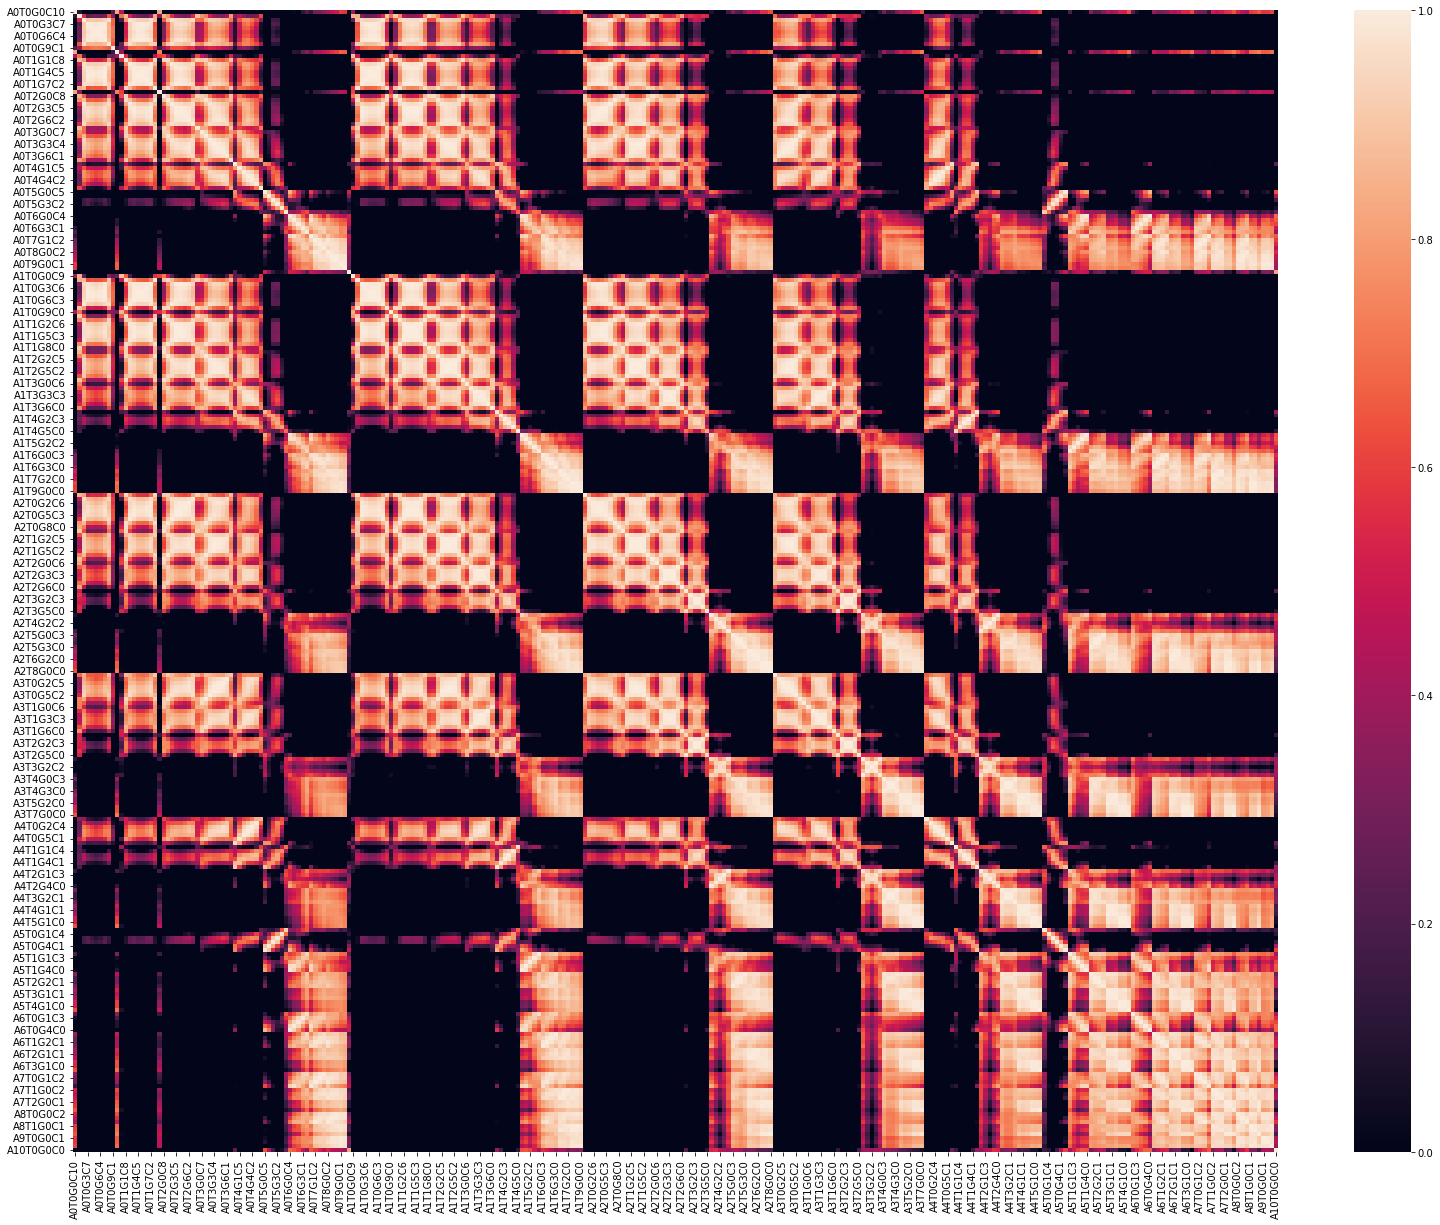

CPU times: user 13.2 s, sys: 379 ms, total: 13.6 s
Wall time: 13.3 s


In [25]:
%%time
if ( 1 ) :
    # feature correlation
    # many features are highly correlated which means that we could possibly re-factor features to orthogonal
    plt.figure(figsize=(27, 21))  # was 18,14, seems to be only showing lables of every 3rd
    temp_df = train_i.query("( gcd == 1)")[FEATURES_RAW]  #.iloc[ : , : 80]  # [row_start:row_end , col_start, col_end]
    print( temp_df.shape )  

    correlation_df = temp_df.corr()  # can use DataFrame.corrwith( other ) to compare 2 data frames, https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html
    # produces a 286 x 286 correlation matrix
    print( correlation_df.shape ) # (286, 286)
    
    sns.heatmap(  # https://seaborn.pydata.org/generated/seaborn.heatmap.html
        correlation_df, 
        vmin=0
    )
    plt.show()
    
    # correlation_df.sum()  # we get positive & negative, each row ( or column ) will have a 1 on the diagonal & 

In [26]:
%%time
if ( 0 ) :

    # could modify data of low-res so that is achieved correlation of high-res?
    # take original data & multiply by correlation matrix to produce 'correlated' data
    #print( train_i[FEATURES_RAW].shape, correlation_df[FEATURES_RAW].shape )
    #print( train_i[FEATURES_RAW].columns )
    #print( correlation_df.columns )
    train_2_df = train_i[FEATURES_RAW].copy()
    #print( train_2_df.columns )
    train_2_df = train_2_df.dot( correlation_df )
    train_2_df['gcd'] = train_i['gcd']
    temp_df = train_2_df.query("( gcd == 10000 )")  #.iloc[ : , : 80]  # [row_start:row_end , col_start, col_end]
    print( temp_df.shape )
    correlation2_df = temp_df.corr()  # can use DataFrame.corrwith( other ) to compare 2 data frames, https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html
    
    plt.figure(figsize=(27, 21))
    sns.heatmap(  # https://seaborn.pydata.org/generated/seaborn.heatmap.html
        correlation2_df, 
        vmin=0
    )
    plt.show()


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


In [27]:
%%time
if ( 0 ) :  # BoxPlot data ( at GCD == 1)
    plt.figure(figsize=(27, 21))  # was 18,14, seems to be only showing labels of every 3rd
    for ii in range( num_classes ) :
        temp1_df = train_i[ ( train.target_enc == ii ) ]  #("( gcd == 1 )")
        temp1_df = temp1_df[ temp1_df.gcd == 1 ]
        plt.figure(figsize=(36, 4))
        temp1_df.boxplot(  )
        plt.show()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs


In [28]:
%%time
if ( 0 ) :
    # feature correlation
    # many features are highly correlated which means that we could possibly re-factor features to orthogonal
    plt.figure(figsize=(27, 21))  # was 18,14, seems to be only showing lables of every 3rd
    #correlation = train.corr()
    #correlation = train_i.corr()
    for ii in range( num_classes ) :
        temp1_df = train_i[ ( train.target_enc == ii ) ]  #("( gcd == 1 )")
        temp1_df = temp1_df[ temp1_df.gcd == 1 ]
        s1 = temp1_df.mean()
        for jj in range ( ii+1, num_classes ) :
            temp2_df = train_i[ ( train.target_enc == jj ) ]  #("( gcd == 1 )")
            temp2_df = temp2_df[ temp2_df.gcd == 1 ]
            s2 = temp2_df.mean()
            plt.figure(figsize=(36, 4))
            #plt.boxplot( temp1_df )
            plt.plot( s1, label = ii )
            plt.plot( s2, label = jj)
            plt.plot( s2 - s1, label = 'diff' )
            plt.legend()
            plt.show()

    #temp2_df = train_i[ train.target_enc == 1 ]  #("( gcd == 10000 )")
    #print( temp1_df.shape, temp2_df.shape )
    #s1 = temp1_df.mean()
    #s2 = temp2_df.mean()
    
    # corrwith() does pairwise comparison ( e.g. not cross-comparison ) so we can't use 'heatmap' to compar
    #correlation3_df = temp1_df.corrwith( other = temp2_df, axis = 0, drop = True)  # can use DataFrame.corrwith( other ) to compare 2 data frames
    #print( correlation3_df.shape )
    #print( correlation3_df )
    #plt.figure(figsize=(30, 6))
    #plt.plot( s1 )
    #plt.plot( s2 )
    #correlation3_df.T.plot()
    #sns.heatmap(    correlation3_df,         vmin=0    )
    #plt.show()

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.58 µs


In [29]:
# Naive Model
# attempting to incrementally label ( pseudo label ) test data
# how to handle low-res?
# manually average the data 'upscale' to GCD 1
# for each column (286) of source, column of new = f( certain columns up to 26 )
# would need to derive which columns & what weights
# which model? LightGBM is tree ( as is dt, et, rf ), KNN will probably be bad on low-res data

# AutoEncoder Model

In [30]:
train.head()

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,A0T0G10C0,A0T1G0C9,A0T1G1C8,A0T1G2C7,A0T1G3C6,A0T1G4C5,A0T1G5C4,A0T1G6C3,A0T1G7C2,A0T1G8C1,A0T1G9C0,A0T2G0C8,A0T2G1C7,A0T2G2C6,A0T2G3C5,A0T2G4C4,A0T2G5C3,A0T2G6C2,A0T2G7C1,A0T2G8C0,A0T3G0C7,A0T3G1C6,A0T3G2C5,A0T3G3C4,A0T3G4C3,A0T3G5C2,A0T3G6C1,A0T3G7C0,A0T4G0C6,A0T4G1C5,A0T4G2C4,A0T4G3C3,A0T4G4C2,A0T4G5C1,A0T4G6C0,A0T5G0C5,A0T5G1C4,A0T5G2C3,A0T5G3C2,A0T5G4C1,A0T5G5C0,A0T6G0C4,A0T6G1C3,A0T6G2C2,A0T6G3C1,A0T6G4C0,A0T7G0C3,A0T7G1C2,A0T7G2C1,A0T7G3C0,A0T8G0C2,A0T8G1C1,A0T8G2C0,A0T9G0C1,A0T9G1C0,A0T10G0C0,A1T0G0C9,A1T0G1C8,A1T0G2C7,A1T0G3C6,A1T0G4C5,A1T0G5C4,A1T0G6C3,A1T0G7C2,A1T0G8C1,A1T0G9C0,A1T1G0C8,A1T1G1C7,A1T1G2C6,A1T1G3C5,A1T1G4C4,A1T1G5C3,A1T1G6C2,A1T1G7C1,A1T1G8C0,A1T2G0C7,A1T2G1C6,A1T2G2C5,A1T2G3C4,A1T2G4C3,A1T2G5C2,A1T2G6C1,A1T2G7C0,A1T3G0C6,A1T3G1C5,A1T3G2C4,A1T3G3C3,A1T3G4C2,A1T3G5C1,A1T3G6C0,A1T4G0C5,A1T4G1C4,A1T4G2C3,A1T4G3C2,A1T4G4C1,A1T4G5C0,A1T5G0C4,A1T5G1C3,A1T5G2C2,A1T5G3C1,A1T5G4C0,A1T6G0C3,A1T6G1C2,A1T6G2C1,A1T6G3C0,A1T7G0C2,A1T7G1C1,A1T7G2C0,A1T8G0C1,A1T8G1C0,A1T9G0C0,A2T0G0C8,A2T0G1C7,A2T0G2C6,A2T0G3C5,A2T0G4C4,A2T0G5C3,A2T0G6C2,A2T0G7C1,A2T0G8C0,A2T1G0C7,A2T1G1C6,A2T1G2C5,A2T1G3C4,A2T1G4C3,A2T1G5C2,A2T1G6C1,A2T1G7C0,A2T2G0C6,A2T2G1C5,A2T2G2C4,A2T2G3C3,A2T2G4C2,A2T2G5C1,A2T2G6C0,A2T3G0C5,A2T3G1C4,A2T3G2C3,A2T3G3C2,A2T3G4C1,A2T3G5C0,A2T4G0C4,A2T4G1C3,A2T4G2C2,A2T4G3C1,A2T4G4C0,A2T5G0C3,A2T5G1C2,A2T5G2C1,A2T5G3C0,A2T6G0C2,A2T6G1C1,A2T6G2C0,A2T7G0C1,A2T7G1C0,A2T8G0C0,A3T0G0C7,A3T0G1C6,A3T0G2C5,A3T0G3C4,A3T0G4C3,A3T0G5C2,A3T0G6C1,A3T0G7C0,A3T1G0C6,A3T1G1C5,A3T1G2C4,A3T1G3C3,A3T1G4C2,A3T1G5C1,A3T1G6C0,A3T2G0C5,A3T2G1C4,A3T2G2C3,A3T2G3C2,A3T2G4C1,A3T2G5C0,A3T3G0C4,A3T3G1C3,A3T3G2C2,A3T3G3C1,A3T3G4C0,A3T4G0C3,A3T4G1C2,A3T4G2C1,A3T4G3C0,A3T5G0C2,A3T5G1C1,A3T5G2C0,A3T6G0C1,A3T6G1C0,A3T7G0C0,A4T0G0C6,A4T0G1C5,A4T0G2C4,A4T0G3C3,A4T0G4C2,A4T0G5C1,A4T0G6C0,A4T1G0C5,A4T1G1C4,A4T1G2C3,A4T1G3C2,A4T1G4C1,A4T1G5C0,A4T2G0C4,A4T2G1C3,A4T2G2C2,A4T2G3C1,A4T2G4C0,A4T3G0C3,A4T3G1C2,A4T3G2C1,A4T3G3C0,A4T4G0C2,A4T4G1C1,A4T4G2C0,A4T5G0C1,A4T5G1C0,A4T6G0C0,A5T0G0C5,A5T0G1C4,A5T0G2C3,A5T0G3C2,A5T0G4C1,A5T0G5C0,A5T1G0C4,A5T1G1C3,A5T1G2C2,A5T1G3C1,A5T1G4C0,A5T2G0C3,A5T2G1C2,A5T2G2C1,A5T2G3C0,A5T3G0C2,A5T3G1C1,A5T3G2C0,A5T4G0C1,A5T4G1C0,A5T5G0C0,A6T0G0C4,A6T0G1C3,A6T0G2C2,A6T0G3C1,A6T0G4C0,A6T1G0C3,A6T1G1C2,A6T1G2C1,A6T1G3C0,A6T2G0C2,A6T2G1C1,A6T2G2C0,A6T3G0C1,A6T3G1C0,A6T4G0C0,A7T0G0C3,A7T0G1C2,A7T0G2C1,A7T0G3C0,A7T1G0C2,A7T1G1C1,A7T1G2C0,A7T2G0C1,A7T2G1C0,A7T3G0C0,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target,target_enc,sample_weight,gcd
0,-9.536743e-07,-0.00001,-0.000043,-0.000114,-0.0002,-0.00024,-0.0002,-0.000114,-0.000043,-0.00001,-9.536743e-07,-0.00001,-0.000086,-0.000343,-0.000801,-0.001202,-0.001202,-0.000801,-0.000343,-0.000086,-0.00001,-0.000043,-0.000343,-0.001202,0.007597,-0.003004,-0.002403,0.008798,-0.000343,-0.000043,-0.000114,-0.000801,-0.002403,-0.004005,0.005995,-0.002403,-0.000801,-0.000114,-0.0002,-0.001202,-0.003004,-0.004005,-0.003004,-0.001202,-0.0002,-0.00024,-0.001202,-0.002403,-0.002403,0.008798,-0.00024,-0.0002,-0.000801,-0.001202,-0.000801,-0.0002,-0.000114,-0.000343,-0.000343,-0.000114,-0.000043,-0.000086,-0.000043,-0.00001,-0.00001,-9.536743e-07,-0.00001,-0.000086,-0.000343,-0.000801,0.008798,-0.001202,-0.000801,-0.000343,-0.000086,-0.00001,-0.000086,-0.000687,-0.002403,0.005193,0.013992,0.015193,-0.002403,-0.000687,-0.000086,-0.000343,-0.002403,0.01279,0.007984,0.017984,0.00279,-0.002403,-0.000343,-0.000801,-0.004807,-0.002016,-0.006022,-0.002016,-0.004807,0.009199,-0.001202,0.003992,-0.012016,-0.002016,-0.006008,-0.001202,-0.001202,0.015193,0.00279,-0.004807,0.008798,-0.000801,-0.002403,-0.002403,-0.000801,-0.000343,0.009313,-0.000343,-0.000086,-0.000086,-0.00001,-0.000043,-0.000343,-0.001202,-0.002403,-0.003004,-0.002403,-0.001202,-0.000343,-0.000043,-0.000343,-0.002403,0.01279,-0.012016,0.007984,-0.00721,-0.002403,-0.000343,-0.001202,-0.00721,0.001976,-0.024033,-0

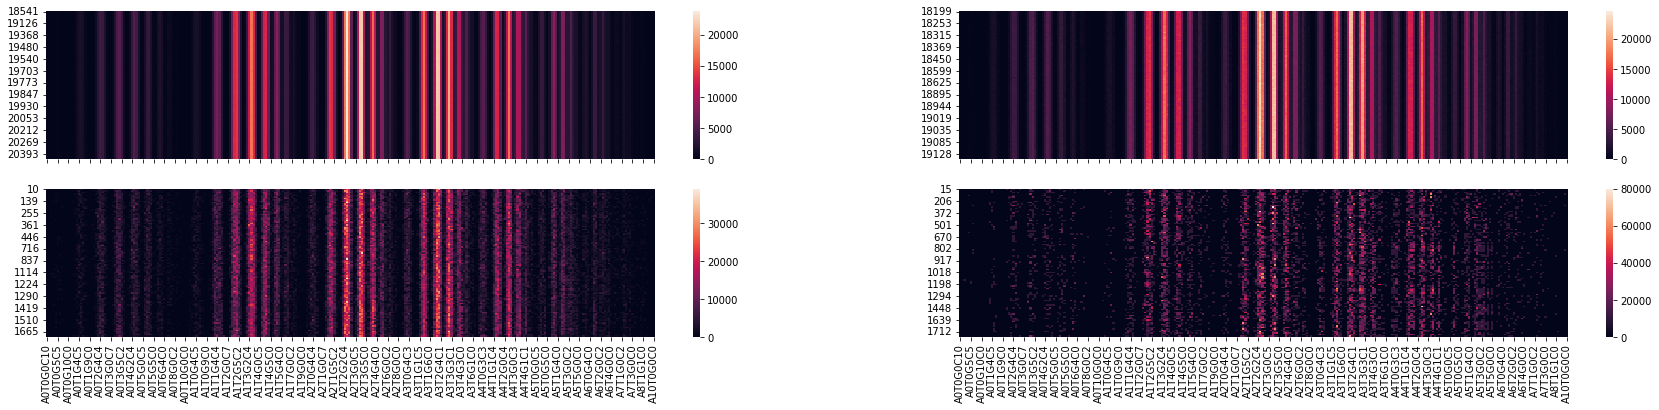

In [31]:
# display 'spectra' 9 for a specific class x 4 different resolutions
fig, ax = plt.subplots(2, 2, figsize=(30,6), sharex=True)
target_enc = 4
sns.heatmap(train_i[(train.target_enc==target_enc) & (train_i.gcd==1)][FEATURES_RAW].head(100), ax=ax[0,0])
sns.heatmap(train_i[(train.target_enc==target_enc) & (train_i.gcd==10)][FEATURES_RAW].head(100), ax=ax[0,1])
sns.heatmap(train_i[(train.target_enc==target_enc) & (train_i.gcd==1000)][FEATURES_RAW].head(100), ax=ax[1,0])
sns.heatmap(train_i[(train.target_enc==target_enc) & (train_i.gcd==10000)][FEATURES_RAW].head(100), ax=ax[1,1])
plt.show()

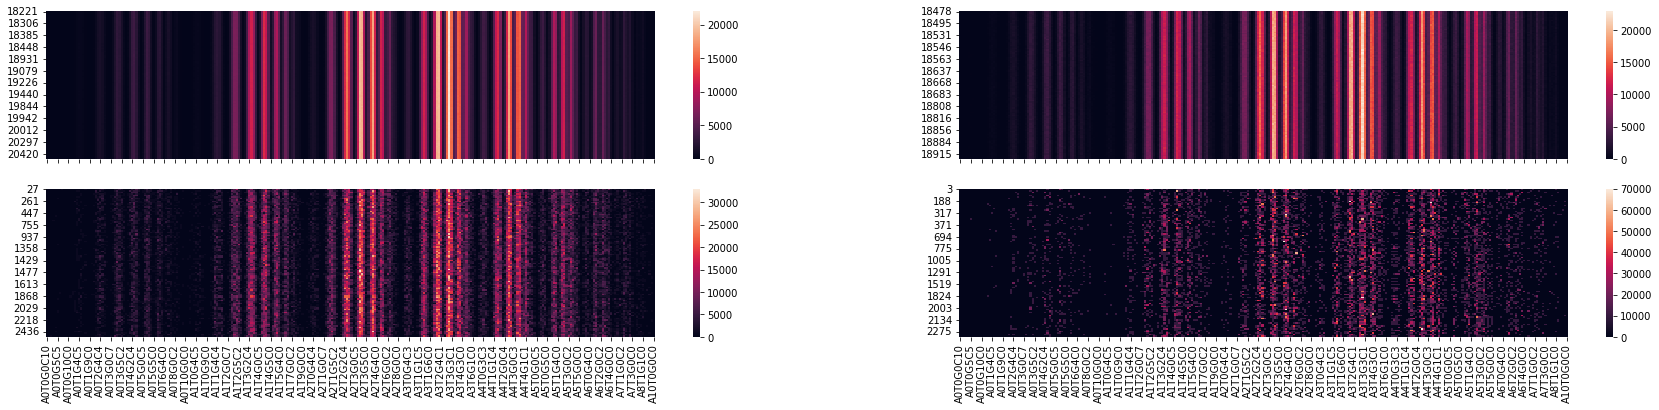

In [32]:
# display 'spectra' 9 for a specific class x 4 different resolutions
fig, ax = plt.subplots(2, 2, figsize=(30,6), sharex=True)
target_enc = 0
sns.heatmap(train_i[(train.target_enc==target_enc) & (train_i.gcd==1)][FEATURES_RAW].head(100), ax=ax[0,0])
sns.heatmap(train_i[(train.target_enc==target_enc) & (train_i.gcd==10)][FEATURES_RAW].head(100), ax=ax[0,1])
sns.heatmap(train_i[(train.target_enc==target_enc) & (train_i.gcd==1000)][FEATURES_RAW].head(100), ax=ax[1,0])
sns.heatmap(train_i[(train.target_enc==target_enc) & (train_i.gcd==10000)][FEATURES_RAW].head(100), ax=ax[1,1])
plt.show()

In [33]:
class classAutoencoder( Model ) :
    def __init__(self, latent_dim) :
        super( classAutoencoder, self).__init__()
        self.latent_dim = latent_dim
        
        input_layer = keras.Input( shape = ( 286, ), name = 'in_286' )

        input_layer2 = keras.Input( shape = ( 3, ), name = 'in_TrainTestMask' )  # [ Train/Known, Test/Unknown, Mask ]
        input_layer3 = keras.Input( shape = ( 4, ), name = 'in_GCD' )  # [ GCD { 1,10,1000,10000 } ,? Mask ]
        input_layer4 = keras.Input( shape = ( num_classes + 0 * 2 ), name = 'in_ClassMask' )  # [ target_class -> hot1, Unknown, Mask ]

        # if we know target_class, we know: Domain, Phylum, Class, Order, Family, Genus, Species  ( each has limited choices or 'masked' )
        #  & each choice probabilisticaly leads to choices at next level ( hierarchical )
        # if we don't know target_class, we infer: Domain, Phylum, Class, Order, Family, Genus, Species
        # the 286 raw input features have relationships of proximity to each other
        #  e.g.(ATGC) A4C3G2T1 is 4,3,2,1 and next to 4,2,3,1 ( for instance ) ( 26 total possible neighbors in 3D )
        # could make explict links from columns through ACGT counts ( ? ordinal )

        # Encoder
        x = Dense( 32, activation = 'swish', kernel_initializer='he_uniform', name = 'in_dense1')(input_layer)
        x = Concatenate( name = 'concatenate')( [ x, input_layer2, input_layer3, input_layer4 ] )
        x = Dense( 32, activation = 'swish', kernel_initializer='he_uniform', name = 'dense2')(x)
    
        self.encoder = x
        
        
        # Decoder
        x = Dense( 32, activation = 'swish', kernel_initializer='he_uniform', name = 'dense3')(x)
        output_layer = Dense( 286, activation = 'swish', kernel_initializer='he_uniform', name = 'output286')(x)

        output_layer2 = Dense( units = 3, name = 'oTrainTestMask' )(x)  # [ Train/Known, Test/Unknown, Mask ]
        output_layer3 = Dense( units = 4, name = 'oGCD' )(x)  # [ GCD { 1,10,1000,10000 } ,? Mask ]
        output_layer4 = Dense( units = num_classes + 0 * 2, name = 'oClassMask' )(x)  # [ target_class -> hot1, Unknown, Mask ]
        #output_layer = Concatenate()( [ output_layer, output_layer2, output_layer3, output_layer4 ] )

        # Autoencoder
        #autoencoder_model = Model( inputs = [input_layer], outputs = [output_layer], name = 'autoencoder' )
        autoencoder_model = Model( 
            inputs = [ input_layer, input_layer2, input_layer3, input_layer4 ]
            , outputs = [ output_layer, output_layer2, output_layer3, output_layer4 ]
            , name = 'autoencoder'
        )
        self.decoder = Concatenate()( [ output_layer, output_layer2, output_layer3, output_layer4 ] )
        
    def call( self, inputs ) :
        encoded = self.encoder(x)
        decoded = self.decoder( encoded )
        return decoded

In [34]:
# AutoEncoder
# https://www.tensorflow.org/tutorials/generative/autoencoder
def f_autoencoder_model( latent_dimension = 32 ) :
      
    # This is our input 
    input_layer = keras.Input( shape = ( 286, ), name = 'in_286' )

    input_layer2 = keras.Input( shape = ( 3, ), name = 'in_TrainTestMask' )  # [ Train/Known, Test/Unknown, Mask ]
    input_layer3 = keras.Input( shape = ( 4, ), name = 'in_GCD' )  # [ GCD { 1,10,1000,10000 } ,? Mask ]
    input_layer4 = keras.Input( shape = ( num_classes + 0 * 2 ), name = 'in_ClassMask' )  # [ target_class -> hot1, Unknown, Mask ]

    # if we know target_class, we know: Domain, Phylum, Class, Order, Family, Genus, Species  ( each has limited choices or 'masked' )
    #  & each choice probabilisticaly leads to choices at next level ( hierarchical )
    # if we don't know target_class, we infer: Domain, Phylum, Class, Order, Family, Genus, Species
    # the 286 raw input features have relationships of proximity to each other
    #  e.g.(ATGC) A4C3G2T1 is 4,3,2,1 and next to 4,2,3,1 ( for instance ) ( 26 total possible neighbors in 3D )
    # could make explict links from columns through ACGT counts ( ? ordinal )

    # Encoder
    x = Dense( latent_dimension, activation = 'swish', kernel_initializer='he_uniform', name = 'in_dense1')(input_layer)
    x = Concatenate( name = 'concatenate')( [ x, input_layer2, input_layer3, input_layer4 ] )
    x = Dense( latent_dimension, activation = 'swish', kernel_initializer='he_uniform', name = 'dense2')(x)
    
    if ( 0 == 1 ) : # variational autoencoder  # https://keras.io/examples/generative/vae/
        z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    x = Dense( latent_dimension, activation = 'swish', kernel_initializer='he_uniform', name = 'dense3')(x)
    output_layer = Dense( 286, activation = 'swish', kernel_initializer='he_uniform', name = 'output286')(x)

    output_layer2 = Dense( units = 3, name = 'oTrainTestMask' )(x)  # [ Train/Known, Test/Unknown, Mask ]
    output_layer3 = Dense( units = 4, name = 'oGCD' )(x)  # [ GCD { 1,10,1000,10000 } ,? Mask ]
    output_layer4 = Dense( units = num_classes + 0 * 2, name = 'oClassMask' )(x)  # [ target_class -> hot1, Unknown, Mask ]
    #output_layer = Concatenate()( [ output_layer, output_layer2, output_layer3, output_layer4 ] )

    # Autoencoder
    #autoencoder_model = Model( inputs = [input_layer], outputs = [output_layer], name = 'autoencoder' )
    autoencoder_model = Model( 
        inputs = [ input_layer, input_layer2, input_layer3, input_layer4 ]
        , outputs = [ output_layer, output_layer2, output_layer3, output_layer4 ]
        , name = 'autoencoder'
    )

    #autoencoder_model.compile( optimizer="adam", loss="binary_crossentropy" )
    autoencoder_model.compile( optimizer = "adam", loss = 'mse')  # mse = mean-square-error

    autoencoder_model.summary()
    print( 'inputs', autoencoder_model.inputs )
    print( 'ouputs', autoencoder_model.outputs )
    
    return autoencoder_model

    # with simplest model, we get 4s 5ms/step - loss: -27231.8594 - val_loss: -27244.3555

In [35]:
autoencoder_model = f_autoencoder_model( latent_dimension = 64 )

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_286 (InputLayer)             [(None, 286)]        0                                            
__________________________________________________________________________________________________
in_dense1 (Dense)               (None, 64)           18368       in_286[0][0]                     
__________________________________________________________________________________________________
in_TrainTestMask (InputLayer)   [(None, 3)]          0                                            
__________________________________________________________________________________________________
in_GCD (InputLayer)             [(None, 4)]          0                                            
________________________________________________________________________________________

2022-02-21 22:53:50.996531: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


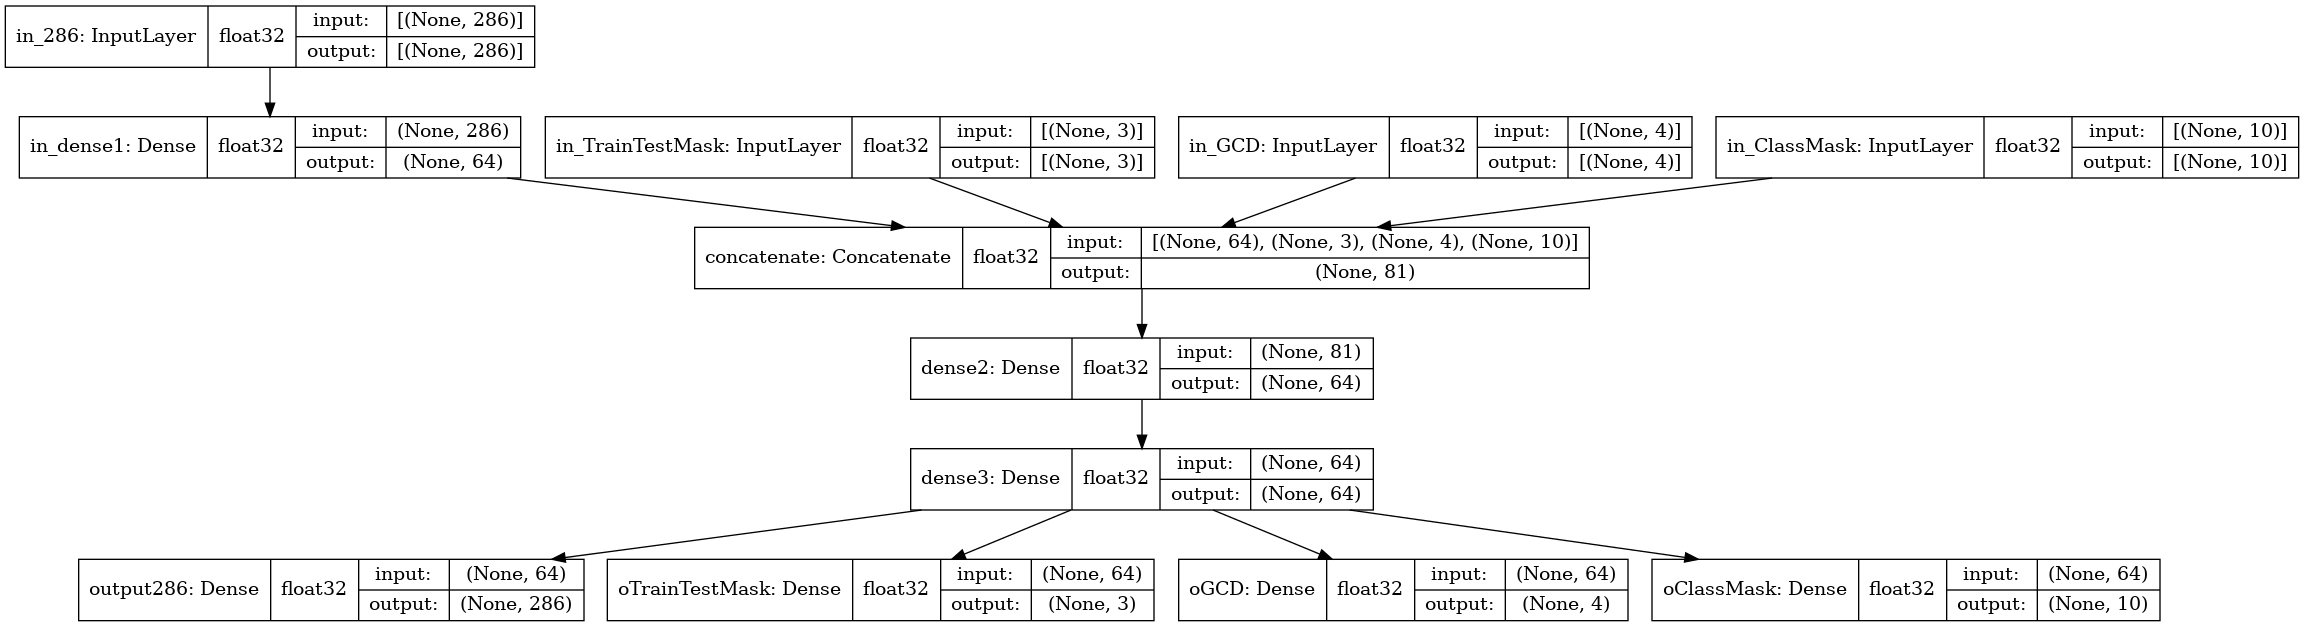

In [36]:
plot_model(
    autoencoder_model, to_file='model_plot.png'
    , show_shapes=True
    , show_dtype= True
    , show_layer_names=True
    #, show_layer_activations=True
)

In [37]:
%time
# ? memory issue
# expect
autoencoder_data = train_i[FEATURES_RAW].to_numpy()
autoencoder_data = autoencoder_data.astype('float32') / 10000000  # normalizes each row so that sum is 1.0
# Normalize the data to [0,1].
autoencoder_data = autoencoder_data.reshape((len(autoencoder_data), np.prod(autoencoder_data.shape[1:])))
# hot-1 encode other columns

gcd_v = train_i['gcd'].values
enc_GCD = OneHotEncoder(categories = 'auto', drop = None, sparse = False)
GCD_ar = enc_GCD.fit_transform( gcd_v.reshape(-1,1) )

#ClassMask_v = train['target_enc'][70000:70010].values
ClassMask_v = train['target_enc'].values
enc_class = OneHotEncoder(categories = 'auto', drop = None, sparse = False)
ClassMask_ar = enc_class.fit_transform( ClassMask_v.reshape(-1,1) )
train_data = train_i[FEATURES_RAW].to_numpy() / 10000000.0

train_data.describe()

ClassMask_masked_v = [0,0,0,0,0,0,0,0,0,0]  # train['target_enc'].values
ClassMask_masked_ar = np.full( shape = ( len(train_data), 10 ), fill_value = ClassMask_masked_v )   # list object [1,0,0], tuple object (1,0,0)

# now we want 3 colums, each set to 1,0,0
fill_value = [1,0,0] # [[1],[0],[0]]
TrainTestMask_ar = np.full( shape = ( len(autoencoder_data), 3 ), fill_value = fill_value )   # list object [1,0,0], tuple object (1,0,0)

print( 'shapes', autoencoder_data.shape, TrainTestMask_ar.shape, GCD_ar.shape, ClassMask_ar.shape )
autoencoder_in_data = [ autoencoder_data, TrainTestMask_ar, GCD_ar, ClassMask_masked_ar ]
autoencoder_out_data = [ autoencoder_data, TrainTestMask_ar, GCD_ar, ClassMask_ar ]

#print( 'autoencoder_data.shape', autoencoder2_data.shape )

# get a newly initialized model (? otherwise re-fit() to existing )
autoencoder_model = f_autoencoder_model( latent_dimension = 64 )

epoch_max = 40

history = autoencoder_model.fit(
    x = autoencoder_in_data,
    y = autoencoder_out_data,  # perhaps y should be unmasked but x should be masked
    epochs = epoch_max,
    batch_size = 128,
    shuffle = True,
    # sample_weight = sample_weight,
    validation_data = ( autoencoder_in_data, autoencoder_out_data )  # could be test & test
)
# ValueError: Dimensions must be equal, but are 286 and 303 for '{{node binary_crossentropy/mul}} = Mul[T=DT_FLOAT](IteratorGetNext:4, binary_crossentropy/Log)' with input shapes: [?,286], [?,303].

# Epoch 1/10
# 969/969 [==============================] - 7s 6ms/step - loss: 0.0033 - val_loss: 0.0032
# Epoch 10/10
# 969/969 [==============================] - 5s 5ms/step - loss: 0.0034 - val_loss: 0.0034

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.3 µs


AttributeError: 'numpy.ndarray' object has no attribute 'describe'

In [ ]:
print(history.params)
print(history.history.keys())

In [ ]:
import matplotlib.pyplot as plt

fold_scores = [history]

for fold in range(len(fold_scores)):
    history_f = fold_scores[fold]

    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(14,4))
    fig.suptitle('.fit() History - Fold : '+str(fold), fontsize=14)
        
    for ix, key_val in enumerate( history_f.history.keys() ) :
        if ( key_val[0:4] == 'val_' ) : continue
        plt.subplot( 1, 5, ix + 1 )
        plt.plot(history_f.history[key_val], label= [key_val])
        plt.plot(history_f.history['val_' + key_val ], label= ['val_' + key_val])
        plt.legend(['train', 'validate'], loc='upper left')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title( key_val )
        plt.grid()

In [ ]:
%%time
# Test autoencoder with some/all data ( train, test )
# evaluate 'confusion' 

#train_data = train_i[FEATURES_RAW][70000:70010].to_numpy() / 10000000.0
#train_data = train_i[FEATURES_RAW].to_numpy() / 10000000.0
fill_value = [1,0,0] # [[1],[0],[0]]

TrainTestMask_ar = np.full( shape = ( len(train_data), 3 ), fill_value = fill_value )   # list object [1,0,0], tuple object (1,0,0)

#gcd_v = train_i['gcd'][70000:70010].values
gcd_v = train_i['gcd'].values
GCD_ar = enc_GCD.transform( gcd_v.reshape(-1,1) )

#ClassMask_v = train['target_enc'][70000:70010].values
ClassMask_v = train['target_enc'].values
enc_class = OneHotEncoder(categories = 'auto', drop = None, sparse = False)
ClassMask_ar = enc_class.fit_transform( ClassMask_v.reshape(-1,1) )

ClassMask_masked_v = [0,0,0,0,0,0,0,0,0,0]  # train['target_enc'].values
ClassMask_masked_ar = np.full( shape = ( len(train_data), 10 ), fill_value = ClassMask_masked_v )   # list object [1,0,0], tuple object (1,0,0)

temp_data = [ train_data, TrainTestMask_ar, GCD_ar, ClassMask_masked_ar  ]

y_286, y_TTM, y_GCD, y_CM = autoencoder_model.predict(
    temp_data
    , verbose = 1
)  # augment the input with TestTrainMask, GCD, Class 

fig, ax = plt.subplots(2, 1, figsize=(14,6), sharex=True)
sns.heatmap(train_data, ax=ax[0])
sns.heatmap(y_286, ax=ax[1])
plt.show()

# output not expected
# compare other outputs to expected
#print( TrainTestMask_ar, y_TTM )
#print( GCD_ar, y_GCD )

In [ ]:
from sklearn.metrics import confusion_matrix
# keras_confusion_matrix expects arrays of ints, not one-hot encodings, so we probably need to do argmode()

y_true = tf.argmax( ClassMask_ar, axis = 1)
y_predict = tf.argmax( y_CM, axis = 1)
#print( y_true, y_predict )

print( y_true.shape, y_predict.shape )  # (123993,) (123993,)
plt.figure(figsize=(12, 6))
confusion_matrix_result = confusion_matrix( y_true, y_predict )
# xticklables = 'predicted', yticklables = 'true'
s = sns.heatmap( confusion_matrix_result, annot = True, annot_kws={"size": 8}, fmt = "" )
s.set(xlabel='predicted', ylabel='true')

In [ ]:
# run the 'masked' training data through the AutoEncoder
# initial result is that everything comes up class 7
#ClassMask_v = train['target_enc'][70000:70010].values
ClassMask2_v = [0,0,0,0,0,0,0,0,0,0]  # train['target_enc'].values
ClassMask2_ar = np.full( shape = ( len(train_data), 10 ), fill_value = ClassMask2_v )   # list object [1,0,0], tuple object (1,0,0)

temp_data2 = [ train_data, TrainTestMask_ar, GCD_ar, ClassMask2_ar  ]

y_2862, y_TTM2, y_GCD2, y_CM2 = autoencoder_model.predict(
    temp_data2
    , verbose = 1
)  # augment the input with TestTrainMask, GCD, Class

#y_true = tf.argmax( ClassMask_ar, axis = 1)
y_predict2 = tf.argmax( y_CM2, axis = 1)
#print( y_true, y_predict )

print( y_true.shape, y_predict2.shape )  # (123993,) (123993,)
plt.figure(figsize=(12, 6))
confusion_matrix_result = confusion_matrix( y_true, y_predict2 )
sns.heatmap( confusion_matrix_result , annot = True, annot_kws={"size": 8}, fmt = "" )

In [ ]:
#print( y_CM[0:2] )
#print( y_CM2[0:2] )
print( tf.argmax( y_CM[0:2], axis = 1), y_CM[0:2] )
print( tf.argmax( y_CM2[0:2], axis = 1), y_CM2[0:2] )

In [ ]:
visualize_model_layers( autoencoder_model )

In [ ]:
# Visualize some data flowing through the model
# low-res vs. high-res
# full or masked
# train or test

if ( 1 == 1 ) :
    print( len( temp_data ) )  #4
    print( temp_data[0].shape ) # (123993, 286)
    print( temp_data[1].shape ) # (123993, 3)
    #print( temp_data[0:1].shape )  # 'list' object has no attribute 'shape'
    input_data = [ temp_data[0][ 0:4, : ], temp_data[1][ 0:4, : ], temp_data[2][ 0:4, : ], temp_data[3][ 0:4, : ] ]
    #print( input_data )
    #print( input_data[0].shape )  # (123993, 286)
    visualize_model_layer_data( autoencoder_model, X_test = input_data  )
    
# ValueError: Layer model expects 4 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 286) dtype=float32>]
# ValueError: Layer model_1 expects 4 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 286) dtype=float32>]
# 'Concatenate' object has no attribute 'outputs'
# ValueError: Layer model_1 expects 4 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 286) dtype=float32>]

In [ ]:
%%time
# Test autoencoder with some data ( train, test )
# evaluate 'confusion' 
# keras_confusion_matrix expects arrays of ints, not one-hot encodings, so we probably need to do argmode()

#train_data = train_i[FEATURES_RAW][70000:70010].to_numpy() / 10000000.0
train_data = test_i[FEATURES_RAW].to_numpy() / 10000000.0

fill_value = [1,0,0] # [[1],[0],[0]]
TrainTestMask_ar = np.full( shape = ( len(train_data), 3 ), fill_value = fill_value )   # list object [1,0,0], tuple object (1,0,0)

#gcd_v = train_i['gcd'][70000:70010].values
gcd_v = test_i['gcd'].values
GCD_ar = enc_GCD.transform( gcd_v.reshape(-1,1) )

#ClassMask_v = train['target_enc'][70000:70010].values
ClassMask_v = train['target_enc'].values
ClassMask_ar = enc_class.transform( ClassMask_v.reshape(-1,1) )

temp_data = [ train_data, TrainTestMask_ar, GCD_ar, ClassMask_ar  ]

y_286, y_TTM, y_GCD, y_CM = autoencoder_model.predict(temp_data)  # augment the input with TestTrainMask, GCD, Class 


## CONVERT TABULAR DATA TO IMAGES

In [ ]:
# We creatively convert each obserwation to 2D (1 channel) image


if ( USE_2D ) :
    img_rows = 13
    img_cols = 22
    input_shape = ( img_rows, img_cols, 1 )
elif ( USE_3D ) :
    dimensions = 3
    size = 11 # 0-10 
    input_shape = ( size, size, size, 1 )
    
    col_dict = {}
    for col in FEATURES_RAW :
        col_dict[ col ] = coord_of( col )

In [ ]:
# Reshape data into format that can be handled by Conv3D layers.
# https://www.machinecurve.com/index.php/2019/10/18/a-simple-conv3d-example-with-keras/
def reshape3D( df ) :

    #import array # array module
    
    print( 'reshape()', df.shape )
    data_t = []  # list object
    #data_t = array.array
    #data_t = np.empty( df.shape[0], 11, 11, 11 )
    do_ct = 0
    m3d_array = np.zeros((11,11,11))
    for index, row in df.iterrows() :  # itertuples() might be faster
        #if ( do_ct < 3 ) :
            #print( 'index', index )  # random index (if subsampled )
        for col in FEATURES_RAW :
            col_val = row[ col ]
            col_xyz = col_dict[ col ]
            #m3d_array[ col_dict[ col ] ] = row[ col ] # / 1000000.0
            m3d_array[ col_xyz ] = col_val # / 1000000.0
            #if ( do_ct < 2):
                #print( col, col_val, col_xyz, m3d_array.flatten()[0:10] )
        data_t.append( m3d_array.flatten() )
        #if ( do_ct < 2):
            #print( data_t )  # data_t is list of arrays each which is triple indexed
        #data_t[]
        #do_ct += 1 
        
    print( 'data_t', len( data_t ) )  # data_t is a list of arrays, we want shaped to be 
    print( 'data_t 0', data_t[0].flatten()[0:10] )  # data_t is a list of arrays, we want shaped to be 
    print( 'data_t 1', data_t[1].flatten()[0:10] )  # data_t is a list of arrays, we want shaped to be 
    print( 'data_t 2', data_t[2].flatten()[0:10] )  # data_t is a list of arrays, we want shaped to be 
    ret_val = np.asarray( data_t, dtype = np.float32 )
    #ret_val = data_t.reshape( df.shape[0], 11, 11, 11 )
    return ret_val

#print( col_dict )  # mapping from column to coordinate

In [ ]:
%%time
# SLOW
if ( USE_3D ) :
    # slow reshape3D() is slow ( perhaps worse with GPU than CPU )
    train_3d = reshape3D( train_i )  # ?? could also be re-normalized by dividing each cell by 1M
    #train_3d = reshape3D( train_i[56:59] )  # ?? could also be re-normalized by dividing each cell by 1M
    print( 'train_3d', train_3d.shape )  # (123993, 11, 11, 11)
#Wall time: 3min 9s
#Wall time: 6min 23s
# Wall time: 3min 32s
# could save this to file & restore instead of re-derive

In [ ]:
#print(train_3d[2].flatten()[0:10])
train_i.describe()

In [ ]:
if ( USE_3D ) :
    stats.describe( train_3d )  # should match train_i.describe()

In [ ]:
if ( USE_3D ) :
    # show the first 2 records of train_3d
    train_3d[0].flatten()[0:10]

In [ ]:
if ( USE_3D ) :
    train_3d[99].flatten()[0:10]

In [ ]:
%%time
#SLOW
if ( USE_3D ) :
    test_3d = reshape3D( test_i )
    print( test_3d.shape )  # (100000, 11, 11, 11)
# Wall time: 2min 51s

In [ ]:
# This dataset I create only for NN filter and Grad-CAM visualization
scaler = MinMaxScaler()
train_df = pd.DataFrame(scaler.fit_transform(train[FEATURES_RAW]), columns = FEATURES_RAW)
test_df = pd.DataFrame(scaler.transform(test[FEATURES_RAW]), columns = FEATURES_RAW)

lb = LabelEncoder()
enc_target = lb.fit_transform(train.target)
print( list(lb.classes_) )
train_df['target_enc'] = enc_target
train['target_enc'] = enc_target

print( train.target.value_counts() )
print( train.target_enc.value_counts() )

train_df['target'] = train['target']

In [ ]:
#FEATURES_RAW

# Cluster - T-SNE
https://www.kaggle.com/remekkinas/super-learner-ensemble-extree-tuned-lda-umap

In [ ]:
#print( train_i.shape )
#train_sub = train.sample( 10000, random_state= 42 )  # sampling only 10,000 of 173,000.  could further refine by selected classes, gcd resolution
train_sub = train_i.sample( 10000, random_state= 42 )  # sampling only 10,000 of 173,000.  could further refine by selected classes, gcd resolution

In [ ]:
%%time
#SLOW
if ( 0 == 1 ) :
    from sklearn.manifold import TSNE
    from sklearn.preprocessing import StandardScaler

    model = TSNE(n_components=2, random_state=0, perplexity= 50, n_iter=3000)
    tsne_data = model.fit_transform(StandardScaler().fit_transform(train_sub.drop('target', axis = 1).astype(float)))
    tsne_data = np.vstack((tsne_data.T, train_sub.target)).T

    tsne_df = pd.DataFrame(data=tsne_data, columns=("D1", "D2", "target"))

    # not sure exactly what 'FacetGrid()' is doing vs. just a scatter plot
    sns.FacetGrid(tsne_df, hue="target", height=6).map(plt.scatter, 'D1', 'D2').add_legend()
    plt.title('Perplexity= 50, n_iter=3000')
    plt.show()

In [ ]:
%%time
#SLOW
if ( 0 == 1 ) :
    model = TSNE(n_components=3, random_state=0, perplexity= 50, n_iter=3000)
    tsne_data = model.fit_transform(StandardScaler().fit_transform(train_sub.drop('target', axis = 1).astype(float)))
    tsne_data = np.vstack((tsne_data.T, train_sub.target)).T

    tsne_df = pd.DataFrame(data=tsne_data, columns=("D1", "D2", "D3", "target"))

    # sns.FacetGrid(tsne_df, hue="target", height=6).map(plt.scatter, 'D1', 'D2', "D3").add_legend()
    # plt.title('Perplexity= 50, n_iter=3000')
    # plt.show()

    plt.figure(figsize=(50,30))
    map_3d = px.scatter_3d(
        tsne_df, x="D1", y="D2", z="D3",
        labels={'color': 'target'},
        color= train_sub.target,
        color_discrete_sequence=['red', 'seagreen', 'gold', 'black'],
    )

    map_3d.update_traces(marker_size=2)
    map_3d.show()

# Cluster - LinearDiscriminantAnalysis (LDA)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda_data = LDA(n_components=2).fit_transform(train_sub.drop(columns='target'),train_sub.target)
plt.figure(figsize=(10,10))
sns.scatterplot(x = lda_data[:, 0], y = lda_data[:, 1], hue = 'target', data=train_sub)

In [ ]:
lda_data = LDA(n_components=3).fit_transform(train_sub.drop(columns='target'),train_sub.target)
#plt.figure(figsize=(10,10))
#sns.scatterplot(x = lda_data[:, 0], y = lda_data[:, 1], z = lda_data[:, 2], hue = 'target', data=train_sub)
lda_data = np.vstack((lda_data.T, train_sub.target)).T
df = pd.DataFrame(data=lda_data, columns=("D1", "D2", "D3", "target"))
plt.figure(figsize=(50,30))
map_3d = px.scatter_3d(
    df, x="D1", y="D2", z="D3",
    labels={'color': 'target'},
    color= train_sub.target,
    symbol = train_sub.gcd,
    #color_discrete_sequence=['red', 'seagreen', 'gold', 'black'],
)

map_3d.update_traces(marker_size=2)
map_3d.show()

# Cluster - (UMAP)

In [ ]:
%%time
#SLOW
if ( 0 == 1 ) :
    import umap

    embedding_2d = umap.UMAP(random_state = 42 ,n_components=2).fit_transform(train_sub.drop(columns=['target', 'gcd']).to_numpy())
    embedding_3d = umap.UMAP(random_state = 42 ,n_components=3).fit_transform(train_sub.drop(columns=['target', 'gcd']).to_numpy())
else :
    embedding_2d = []
    embedding_3d = []

In [ ]:
if ( embedding_2d ) :
    plt.figure(figsize=(10,10))
    sns.scatterplot(x = embedding_2d[:, 0], y = embedding_2d[:, 1], hue='target', data=train_sub)

In [ ]:
if ( embedding_3d ) :
    embedding_3d = np.vstack((embedding_3d.T, train_sub.target)).T
    df = pd.DataFrame(data=embedding_3d, columns=("D1", "D2", "D3", "target"))

    plt.figure(figsize=(50,30))
    map_3d = px.scatter_3d(
        df, x="D1", y="D2", z="D3",
        labels={'color': 'target'},
        color= train_sub.target,
        symbol = train_sub.gcd,
        #color_discrete_sequence=['red', 'seagreen', 'gold', 'black'],
    )

    map_3d.update_traces(marker_size=2)
    map_3d.show()

## SHOW BACTERIA "SPECTROGRAM" BY CLASS
- Do you see any patterns in images?
- Are bacterias mixed or shifted?

In [ ]:
def plot_bacteria(images, labels, indexes):
    num_row = 10
    num_col = 5

    fig, axes = plt.subplots(num_row, num_col, constrained_layout=True,  sharex=True, sharey=True, figsize=(3*num_col,2*num_row))

    for i in range(len(images)):
        ax = axes[i//num_col, i%num_col]
        image = images[i].reshape(img_rows, img_cols, 1)
        ax.imshow(image, cmap='Spectral')
        ax.set_title(f'{labels[i]}\n{indexes[i]}')
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.5)
    plt.show()

In [ ]:
def plot_bacteria_3d( data, lables, indexes ) :
    num_row = 10
    num_col = 5

    fig, axes = plt.subplots( num_row, num_col, constrained_layout=True,  sharex=True, sharey=True, figsize=(8*num_col,4*num_row))

    # want data to be x,y,z,value, index, target ( e.g. 1 row to many rows )
    
    for i in range(len(lables)):
        
        fig.add_subplot( num_row, num_col, i, projection='3d' )
        #ax = axes[i//num_col, i%num_col]  # 
        #image = images[i].reshape(img_rows, img_cols, 1)
        #ax.imshow(image, cmap='Spectral')
        ax.scatter(
            data[0]
            , data[1]
            , data[2]
            #, marker=m
        )
        ax.set_title(f'{labels[i]}\n{indexes[i]}')
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.5)
    plt.show()

In [ ]:
# https://stackoverflow.com/questions/48672663/matplotlib-render-all-internal-voxels-with-alpha
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d  # NOQA
#from matplotlib.cbook import _backports
from collections import defaultdict
import types

def voxels_function(self, *args, **kwargs):

    if len(args) >= 3:
        # underscores indicate position only
        def voxels_function(__x, __y, __z, filled, **kwargs):
            return (__x, __y, __z), filled, kwargs
    else:
        def voxels_function(filled, **kwargs):
            return None, filled, kwargs

    xyz, filled, kwargs = voxels_function(*args, **kwargs)

    # check dimensions
    if filled.ndim != 3:
        raise ValueError("Argument filled must be 3-dimensional")
    size = np.array(filled.shape, dtype=np.intp)

    # check xyz coordinates, which are one larger than the filled shape
    coord_shape = tuple(size + 1)
    if xyz is None:
        x, y, z = np.indices(coord_shape)
    else:
        x, y, z = (_backports.broadcast_to(c, coord_shape) for c in xyz)

    def _broadcast_color_arg(color, name):
        if np.ndim(color) in (0, 1):
            # single color, like "red" or [1, 0, 0]
            return _backports.broadcast_to(
                color, filled.shape + np.shape(color))
        elif np.ndim(color) in (3, 4):
            # 3D array of strings, or 4D array with last axis rgb
            if np.shape(color)[:3] != filled.shape:
                raise ValueError(
                    "When multidimensional, {} must match the shape of "
                    "filled".format(name))
            return color
        else:
            raise ValueError("Invalid {} argument".format(name))

    # intercept the facecolors, handling defaults and broacasting
    facecolors = kwargs.pop('facecolors', None)
    if facecolors is None:
        facecolors = self._get_patches_for_fill.get_next_color()
    facecolors = _broadcast_color_arg(facecolors, 'facecolors')

    # broadcast but no default on edgecolors
    edgecolors = kwargs.pop('edgecolors', None)
    edgecolors = _broadcast_color_arg(edgecolors, 'edgecolors')

    # include possibly occluded internal faces or not
    internal_faces = kwargs.pop('internal_faces', False)

    # always scale to the full array, even if the data is only in the center
    self.auto_scale_xyz(x, y, z)

    # points lying on corners of a square
    square = np.array([
        [0, 0, 0],
        [0, 1, 0],
        [1, 1, 0],
        [1, 0, 0]
    ], dtype=np.intp)

    voxel_faces = defaultdict(list)

    def permutation_matrices(n):
        """ Generator of cyclic permutation matices """
        mat = np.eye(n, dtype=np.intp)
        for i in range(n):
            yield mat
            mat = np.roll(mat, 1, axis=0)

    for permute in permutation_matrices(3):
        pc, qc, rc = permute.T.dot(size)
        pinds = np.arange(pc)
        qinds = np.arange(qc)
        rinds = np.arange(rc)

        square_rot = square.dot(permute.T)

        for p in pinds:
            for q in qinds:
                p0 = permute.dot([p, q, 0])
                i0 = tuple(p0)
                if filled[i0]:
                    voxel_faces[i0].append(p0 + square_rot)

                # draw middle faces
                for r1, r2 in zip(rinds[:-1], rinds[1:]):
                    p1 = permute.dot([p, q, r1])
                    p2 = permute.dot([p, q, r2])
                    i1 = tuple(p1)
                    i2 = tuple(p2)
                    if filled[i1] and (internal_faces or not filled[i2]):
                        voxel_faces[i1].append(p2 + square_rot)
                    elif (internal_faces or not filled[i1]) and filled[i2]:
                        voxel_faces[i2].append(p2 + square_rot)

                # draw upper faces
                pk = permute.dot([p, q, rc-1])
                pk2 = permute.dot([p, q, rc])
                ik = tuple(pk)
                if filled[ik]:
                    voxel_faces[ik].append(pk2 + square_rot)

    # iterate over the faces, and generate a Poly3DCollection for each voxel
    polygons = {}
    for coord, faces_inds in voxel_faces.items():
        # convert indices into 3D positions
        if xyz is None:
            faces = faces_inds
        else:
            faces = []
            for face_inds in faces_inds:
                ind = face_inds[:, 0], face_inds[:, 1], face_inds[:, 2]
                face = np.empty(face_inds.shape)
                face[:, 0] = x[ind]
                face[:, 1] = y[ind]
                face[:, 2] = z[ind]
                faces.append(face)

        poly = art3d.Poly3DCollection(faces,
            facecolors=facecolors[coord],
            edgecolors=edgecolors[coord],
            **kwargs
        )
        self.add_collection3d(poly)
        polygons[coord] = poly

    return polygons

In [ ]:
#USE_2D
train_df.head()

In [ ]:
%matplotlib inline
# inline or widget or notebook

from IPython.core.display import display, HTML

# Plot bacteria representants (4x 10) 

if ( USE_2D ) :
    sample_count = 5
    images = train_df.groupby("target").sample(sample_count).drop(["target_enc"], axis = 1)
    labels = images.target.values
    indexes = images.index.values
    images = images[FEATURES_RAW].values.reshape(images.shape[0], img_rows, img_cols, 1).astype('float32')
    plot_bacteria(images, labels, indexes)

elif ( USE_3D ) :
    
    from matplotlib import cm, colors
    import types
    
    sample_count = 10

    
    voxels_df = train_df.groupby("target").sample(sample_count).drop(["target_enc"], axis = 1)
    labels = voxels_df.target.values
    indexes = voxels_df.index.values

    # convert each row of 286 values into single 11 x 11 x 11 ( = 1331 ) hypermatrix
    m3d_array = np.zeros((11,11,11)) # initialize as 11x11x11 of zeros, perhaps don't need this
    #m3d_array = np.zeros((1,1,1)) # initialize as 11x11x11 of zeros, perhaps don't need this
    #m3d_array=[]

    colormap = plt.get_cmap( 'Blues' )  # '' spring
    
    mycolormap = colormap( np.arange(colormap.N) )
    alpha = 0.8
    for i in range(len(mycolormap)):
        mycolormap[i][3] = alpha
        if ( i < 10 ) :
            mycolormap[i] = 0,0,0,0
    print( 'mycolormap', mycolormap.shape, mycolormap )
        
    do_one = 0
    df = train_i[0:sample_count]
    for index, row in df.iterrows() :  # itertuples() might be faster
        # print( index )  # random index
        for col in FEATURES_RAW :
            m3d_array[ col_dict[ col ] ] = row[ col ]
            
        if ( do_one <= 10 ) :
            print( 'm3d_array', m3d_array.shape )   # shape is (11,11,11)
            #print( 'plot', m3d_array.shape, m3d_array )   # shape is (11,11,11)
            x,y,z = np.indices( m3d_array.shape ) # only integer scalar arrays can be converted to a scalar index
            #print( x.shape, x )
            vals = m3d_array.flatten()
            print( 'vals', vals.shape, vals )  # 1331 values, many zeros
            # Make the norm
            #norm = colors.Normalize(vmin = np.min(vals), vmax = np.max(vals), clip = False)
            #print( norm.shape, norm )  # 1331 values, many zeros
            #vals_n = ( vals / np.linalg.norm( vals ) )  # should be [0,1.0]
            vals_n = ( vals / vals.max() )  # should be [0,1.0]
            print( 'vals_n', vals_n.shape, vals_n.sum(), vals_n.max(), vals_n )  # 1331 values, many zeros

            #ax.scatter( m3d_array[::], m3d_array[1], m3d_array[2] )  # wants ax.scatter(xs, ys, zs, marker=m)
            #ax.voxels( m3d_array, edgecolor='k' )
            #ax.voxels(x, y, z, filled_2, facecolors=fcolors_2, edgecolors=ecolors_2)
            #ax.voxels(x, y, z, m3d_array, facecolors=colors, edgecolors=colors)

            #f_colors = colormap( vals_n )  # perhaps facecolors can't handle 4th parameter
            #print( 'f_colors', f_colors.shape )  # 1331 values, many zeros
            f_colors_i = (255 * vals_n).astype(int)
            print( 'f_colors_i', f_colors_i.min(), f_colors_i.mean(), f_colors_i.max(), f_colors_i )  # 1331 values, many zeros
            f_colors = mycolormap[ f_colors_i ]
            f_colors = f_colors.reshape( 11, 11, 11, 4 )
            #? set the 4th parameter (transparent) to be < 1.0
            #ax.voxels( m3d_array, facecolors = f_colors, edgecolor = f_colors )  # Invalid RGBA argument: 1.0

            plt.rcParams["figure.figsize"] = [16,9]
            ax = plt.figure().add_subplot( projection = '3d' )
            ax.view_init(-140, 60)
            ax.voxels = types.MethodType( voxels_function, ax )  # first argument must be callable
            ax.voxels( m3d_array, facecolors = f_colors, edgecolors = f_colors )  # Invalid RGBA argument: 1.0
            plt.show()
            
            do_one += 1
    #train_i = { col: ( (train[col] + coord_of(col) ) ) for col in elements }
    #voxel_val[a,b,c] = 

## LETS'S LOOK INTO PATTERNS

In [ ]:
if ( USE_2D ) :
    # Plot first 50 of a single class Bacteroides_fragilis         

    images = train_df.query("target == 'Campylobacter_jejuni'").sort_index()[:50].drop(["target_enc"], axis = 1)
    labels = images.target.values
    indexes = images.index.values
    images = images[FEATURES_RAW].values.reshape(images.shape[0], img_rows, img_cols, 1).astype('float32')

    plot_bacteria(images, labels, indexes)

In [ ]:
if ( USE_2D ) :
    # Plot first n = 50 observations       

    images = train_df.sort_index()[:50].drop(["target_enc"], axis = 1)
    labels = images.target.values
    indexes = images.index.values
    images = images[FEATURES_RAW].values.reshape(images.shape[0], img_rows, img_cols, 1).astype('float32')

    plot_bacteria(images, labels, indexes)

## CREATE NN ARCHITECTURE

Work in progress. Next step will be to optimize NN architecture and hyperparameters.

In [ ]:
#!pip install -q tensorflow-recommenders

# 1-D Model ( 286 original columns + augmentation )

In [ ]:
#import tensorflow_recommenders as tfrs
#from tensorflow.keras import regularizers
from keras.layers import Add, Multiply, Subtract

def get_1dmodel() :
    
    input_shape = ( 286, )  # ( size, size, size, 1 )
    #units = [256, 128, 64] # initial res
    units = [128, 64, 32] # initial res # possible guidelines: number of units should be approx 2/3 in layer ( here 286 ) + out layer ( )
    #units = [64, 32, 16] # lower res
    #units = [32, 16, 8] # lowest res
    dropout_rate = 0.2
    kernel_initializer = 'he_normal' # 'he_uniform'  # he_normal
    
    if ( 0 == 1 ) :  # Sequential notation
        model = Sequential()
        model.add( keras.Input( shape = input_shape ) )
        x1 = Dense( units = units[0], activation='swish', kernel_initializer='he_uniform' )
        model.add( x1 )

        # tensor = tf.math.reciprocal( x, name = 'reciprocal' )
        model.add( Dense(units = units[1], activation='swish', kernel_initializer='he_uniform'))
        # model.add( Dropout( rate = dropout_rate ) )
        model.add( Dense(units = units[2], activation='swish', kernel_initializer='he_uniform'))
        # model.add( Dropout( rate = dropout_rate ) )
        model.add( Dense(num_classes, activation='softmax'))

        model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
        
    else:  # functional notation
        keras.backend.clear_session()
        if ( 0 == 1 ) :
            inputs = keras.Input( shape = input_shape, name = 'InputLayer1' )
            dense1 = Dense( units = units[0], activation = 'swish', kernel_initializer='he_uniform', name = 'dense1' )
            x1 = dense1( inputs )
            #x1 = Dense( units = units[0], activation='swish', kernel_initializer='he_uniform', input_shape=input_shape, name = 'dense1' ) 
            x = Dense( units = units[1], activation='swish', kernel_initializer='he_uniform', name = 'dense2' )(x1)
            x = Dense( units = units[2], activation='swish', kernel_initializer='he_uniform', name = 'dense3' )(x)
            outputs = Dense( num_classes, activation='softmax' )(x)  # also called logits
            
        elif( 0 == 1 ) :
            inputs = keras.Input( shape = input_shape, name = 'InputLayer1' )
            dense1 = Dense( units = units[0], activation = 'swish', kernel_initializer='he_uniform', name = 'dense1' )
            x1 = dense1( inputs )
                
            x = Dense( units = units[1], activation='swish', kernel_initializer='he_uniform', name = 'dense2' )(x1)

            xf = tf.math.reciprocal_no_nan( x, name = 'Reciprocal' )  # alt divide_no_nan()
            cross = x1
            print( 'x1', x1.shape )  # x1 x1 (None, 286, 64)
            for i in range( 1 ):
                cross_units = cross.shape[-1]
                xc = Dense( units = cross_units
                            #, kernel_regularizer = regularizers.l1_l2( l1 = 1e-5, l2 = 1e-4 )  # Ted - add regularizer to reduce over-fitting 
                            # , bias_regularizer=regularizers.l2(1e-4)
                            # , activity_regularizer=regularizers.l2(1e-5)
                            , name=f"cross_{i+1}_dense")(cross)
                cross = Lambda(lambda x: x[0] / x[1] + x[2], name=f"cross_{i+1}")((x1, xc, cross))
            cross = BatchNormalization(name="cross_b_norm")(cross)
            #x = tfrs.dcn.Cross()( x, xf )
            merged = Concatenate(name="network_concatenate")([cross, x])
            outputs = Dense( num_classes, activation='softmax' )(merged)  # also called logits
            
        elif ( 1 == 1 ) :  # Ted 'fancy' model w/ reciprocal
            
            inputs = keras.Input( shape = input_shape, name = 'InputLayer1' )
            
            dense1 = Dense( units = units[0], activation = 'swish', kernel_initializer=kernel_initializer, name = 'dense1' )
            
            x1 = dense1( inputs )
            #x1 = Dropout( rate = dropout_rate )(x1)
            #x1 = BatchNormalization( )(x1)
            x1 = LayerNormalization( )(x1)
            
            x2 = Dense(units = units[1], activation='swish', kernel_initializer=kernel_initializer, name = 'dense2' )(x1)
            #x3 = BatchNormalization( )(x2)
            x3 = LayerNormalization( )(x2)

            #x = Dense( units = units[1], activation='swish', kernel_initializer='he_uniform', name = 'dense2' )(x1)
            # before reciprocal move x3 to [0.0, 1.0] -> R [ 10, 1 ]
            #xf = tf.math.reciprocal_no_nan( x2, name = 'Reciprocal' )  # alt divide_no_nan()
            
            # to do cartesian product of layers, use loop https://stackoverflow.com/questions/59158183/how-to-perform-the-cartesian-product-of-layers-in-keras-tensorflow-during-model
            #xf = BatchNormalization( )(xf) # this makes this worse for val_acc but visualization looks more 'normal/expected'
            #divide = Divide()([x1,])
            #cross = Lambda(lambda v: v[0] * v[1], name="cross")((x3, xf))
            # integrate reciprocal at a / (1+b)
            #merged = Concatenate( name = "network_concatenate" )( [ x3, xf ] )
            merged = Dense(units = units[1], activation='swish', kernel_initializer=kernel_initializer, name = 'dense3' )(x3)
            merged = BatchNormalization( )(merged)
            merged = Dense(units = units[2], activation='swish', kernel_initializer=kernel_initializer, name = 'dense4' )(merged)
            merged = BatchNormalization( )(merged)
            outputs = Dense( num_classes, activation='softmax' )(merged)  # also called logits
            
        else :  #fancy model Total params: 827,182
            # https://www.kaggle.com/ankitkalauni/nnnnnnnnn
            keras.backend.clear_session()
    
            #one neuron
            inputs = keras.Input(shape = input_shape)
            x = BatchNormalization()(inputs)
            x = Dense(364, activation = 'elu', kernel_initializer= 'he_normal')(x)
            x = BatchNormalization()(x)

            x1 = Dense(216, activation = 'elu', kernel_initializer= 'he_normal', name = 'xmerger')(x)
            xmerger = x1
            x1 = Dropout(0.45)(x1)
            x1 = BatchNormalization()(x1)

            x1 = Dense(164, activation = 'elu', kernel_initializer= 'he_normal', name = 'xkeeper')(x1)
            xkeeper = x1 #164
            x1 = Dropout(0.25)(x1)
            x1 = BatchNormalization()(x1)

            x1 = Dense(164, activation = 'elu', kernel_initializer= 'he_normal')(x1)
            x1 = Dropout(0.25)(x1)
            x1 = BatchNormalization()(x1)

            x1 = Dense(164, activation = 'elu', kernel_initializer= 'he_normal')(x1)
            x1 = Dropout(0.25)(x1)
            x1 = BatchNormalization()(x1)

            xmul = Multiply()([x1, xkeeper])
            xadd = Add()([x1, xkeeper])
            xsub = Subtract()([x1, xkeeper])

            xx = Concatenate()([xkeeper, xmul, xadd, xsub, x1]) 

            x1 = Dense(524, activation = 'elu', kernel_initializer= 'he_normal')(xx)
            x1 = Dropout(0.45)(x1)
            x1 = BatchNormalization()(x1)

            x1 = Dense(216, activation = 'elu', kernel_initializer= 'he_normal')(x1)
            x1 = Add()([x1,xmerger])
            x1 = Dropout(0.35)(x1)
            x1 = BatchNormalization()(x1)

            outputs = Dense(num_classes, activation = 'softmax')(x1)
            
        model = Model( inputs = [inputs], outputs = [outputs], name = '1D_model' )
        model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
    
    return model, x1

model1, _ = get_1dmodel()
model1.summary()

# Model: "sequential_6"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# dense_62 (Dense)             (None, 128)               36736     
# _________________________________________________________________
# dense_63 (Dense)             (None, 64)                8256      
# _________________________________________________________________
# dense_64 (Dense)             (None, 32)                2080      
# _________________________________________________________________
# dense_65 (Dense)             (None, 10)                330       
# =================================================================
# Total params: 47,402
# Trainable params: 47,402
# Non-trainable params: 0

# 2D Model ( Conv2D )

In [ ]:
%%capture
# to do - add second input ( gcd, err-cluster, )

def get_2dmodel():
    # could change number of kernels to speed it up.
    kernel_size = (3,3)
    pool_size = (2,2)
    activation = 'swish'  # 'relu'
    padding = 'same'  # 'same'
    
    #filters = [ 32, 8, 8, 16 ]  # low-res -> faster
    filters = [ 64, 16, 16, 32 ]  # low-res -> faster
    #filters = [ 256, 64, 64, 128 ]
    
    #units = [128, 64, 32] # initial res
    units = [64, 32, 16] # lower res
    dropout_rate = 0.1  # was 0.2
    
    model = Sequential()
    x = Conv2D(filters = filters[0], kernel_size=kernel_size, padding='same', activation='swish', input_shape=input_shape, kernel_initializer='he_uniform')
    model.add(x)
    model.add( Conv2D(filters = filters[1], kernel_size=kernel_size, padding='same', activation='swish', kernel_initializer='he_uniform'))
    model.add( MaxPooling2D(pool_size))
    model.add( Dropout( rate = dropout_rate ))
    model.add( Conv2D(filters = filters[2], kernel_size=kernel_size, padding='same', activation = 'swish', kernel_initializer='he_uniform'))
    model.add( Conv2D(filters = filters[3], kernel_size=kernel_size, padding='same', activation = 'swish', kernel_initializer='he_uniform', name='conv_last'))
    model.add( MaxPooling2D(pool_size))
    model.add( Dropout( rate = dropout_rate ))
    model.add( Flatten() ) 
    model.add( Dense(units = units[0], activation='swish', kernel_initializer='he_uniform'))
    model.add( Dense(units = units[1], activation='swish', kernel_initializer='he_uniform'))
    model.add( Dense(units = units[2], activation='swish', kernel_initializer='he_uniform'))
    model.add( Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    
    return model, x

# 3D Model ( Conv3D )

In [ ]:
def get_3dmodel():
    # change Conv2D() to Conv3D()
    # could change number of kernels to speed it up.
    kernel_size = (3,3,3)
    pool_size = (2,2,2)
    activation = 'swish'  # 'relu'
    padding = 'same'  # 'same'  could be 'valid'
    
    #filters = [ 32, 8, 8, 16 ]  # low-res
    filters = [ 64, 16, 16, 32 ]  # low-res
    #filters = [ 256, 64, 64, 128 ]
    
    units = [128, 64, 32] # initial res
    #units = [64, 32, 16] # lower res
    
    print( 'get_3dmodel()', input_shape )
    
    model = Sequential()
    x = Conv3D(filters = filters[0], kernel_size=kernel_size, padding=padding, activation=activation, input_shape=input_shape, kernel_initializer='he_uniform'
              #, use_bias = False
               #, kernel_regularizer
               #, kernel_constraint
               #, bias_initializer = 'zeros'  # default
              )
    
    model.add(x)
    #model.add(Conv3D(filters = filters[1], kernel_size=kernel_size, padding=padding, activation=activation, kernel_initializer='he_uniform'))
    #model.add(MaxPooling3D(pool_size))
    model.add(Dropout(0.2))  # add dropout every layer to reduce over-fit
    #model.add(Conv3D(filters = filters[2], kernel_size=kernel_size, padding=padding, activation = activation, kernel_initializer='he_uniform'))
    #model.add(Conv3D(filters = filters[3], kernel_size=kernel_size, padding=padding, activation = activation, kernel_initializer='he_uniform', name='conv_last'))
    #model.add(MaxPooling3D(pool_size))
    #model.add(Dropout(0.2))
    model.add( Flatten() )
    model.add( Dense(units = units[0], activation=activation, kernel_initializer='he_uniform'))
    model.add( BatchNormalization() )
    model.add( Dense(units = units[1], activation=activation, kernel_initializer='he_uniform'))
    model.add( BatchNormalization() )
    model.add( Dense(units = units[2], activation=activation, kernel_initializer='he_uniform'))
    
    model.add( Dense(num_classes, activation='softmax'))  # use softmax for multi-class classifier

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    
    return model, x

## PLOT MODEL

In [ ]:
if ( USE_2D == 1 ) :
    model_global, _ = get_2dmodel()
    # Total params: 5,463,466 = 896 ( = 32 filters x (3x3x3+1 ) ) + 5451904 ( = 128 units x 42953 = 32 * 1331 + 1 ) + 8256 ( = 64 * ( 128 + 1 )
    # Trainable params: 2,729,594 - use_bias = false, fewer units (1/2) in each dense layer
    #   ? fewer units
elif ( USE_1D == 1 ) :
    model_global, _ = get_1dmodel()
elif ( USE_3D == 1 ) :
    model_global, _ = get_3dmodel()

model_global.summary()
# 923,434 parameters

# 2D model was 256 first-level filters, then 64 2nd level
# ted - probably could be simplified
# Model: "sequential_1"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# conv2d (Conv2D)              (None, 13, 22, 256)       2560      
# _________________________________________________________________
# conv2d_1 (Conv2D)            (None, 13, 22, 64)        147520    
# _________________________________________________________________
# max_pooling2d (MaxPooling2D) (None, 6, 11, 64)         0         
# _________________________________________________________________
# dropout (Dropout)            (None, 6, 11, 64)         0         
# _________________________________________________________________
# conv2d_2 (Conv2D)            (None, 6, 11, 64)         36928     
# _________________________________________________________________
# conv_last (Conv2D)           (None, 6, 11, 128)        73856     
# _________________________________________________________________
# max_pooling2d_1 (MaxPooling2 (None, 3, 5, 128)         0         
# _________________________________________________________________
# dropout_1 (Dropout)          (None, 3, 5, 128)         0         
# _________________________________________________________________
# flatten (Flatten)            (None, 1920)              0         
# _________________________________________________________________
# dense (Dense)                (None, 128)               245888    
# _________________________________________________________________
# dense_1 (Dense)              (None, 64)                8256      
# _________________________________________________________________
# dense_2 (Dense)              (None, 32)                2080      
# _________________________________________________________________
# dense_3 (Dense)              (None, 10)                330       
# =================================================================
# Total params: 517,418
# Trainable params: 517,418
# Non-trainable params: 0
# _________________________________________________________________
                 
# Model: "sequential_1"
# _________________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# conv3d_3 (Conv3D)            (None, 11, 11, 11, 256)   7168      
# _________________________________________________________________
# conv3d_4 (Conv3D)            (None, 11, 11, 11, 64)    442432    
# _________________________________________________________________
# max_pooling3d_2 (MaxPooling3 (None, 5, 5, 5, 64)       0         
# _________________________________________________________________
# dropout_2 (Dropout)          (None, 5, 5, 5, 64)       0         
# _________________________________________________________________
# conv3d_5 (Conv3D)            (None, 5, 5, 5, 64)       110656    
# _________________________________________________________________
# conv_last (Conv3D)           (None, 5, 5, 5, 128)      221312    
# _________________________________________________________________
# max_pooling3d_3 (MaxPooling3 (None, 2, 2, 2, 128)      0         
# _________________________________________________________________
# dropout_3 (Dropout)          (None, 2, 2, 2, 128)      0         
# _________________________________________________________________
# flatten_1 (Flatten)          (None, 1024)              0         
# _________________________________________________________________
# dense_4 (Dense)              (None, 128)               131200    
# _________________________________________________________________
# dense_5 (Dense)              (None, 64)                8256      
# _________________________________________________________________
# dense_6 (Dense)              (None, 32)                2080      
# _________________________________________________________________
# dense_7 (Dense)              (None, 10)                330       
# =================================================================
# Total params: 923,434
# Trainable params: 923,434
# Non-trainable params: 0
# _______________________________________________________

In [ ]:
plot_model(
    model_global, to_file='model_plot.png'
    , show_shapes=True
    #, show_dtype= True
    , show_layer_names=True
    #, show_layer_activations=True
)

In [ ]:
train.head()
#train_i.head()

In [ ]:
train_i.head()

In [ ]:
test_i.head()

## MODEL VALIDATION (k-FOLD) AND PREDICTION

In [ ]:
%%time

print( "Local Time: ", dt.now( tz_NY ).strftime("%Y-%m-%d %H:%M:%S") )

batch_size = 512
epochs = 100  # 100

# FOLD validation
oof_preds = np.zeros((len(train_df), 1))
oof_proba = np.zeros((len(train_df), num_classes))
test_preds = []
fold_scores = []
x = None #This is only for NN filter and Grad-CAM visualizations

#N_FOLDS = 1

kf = StratifiedKFold(
    n_splits = cfg['N_FOLDS']
    , shuffle = True # train seems to be 'ordered' which causes problems
    , random_state = cfg['RANDOM']
)
print(f"Start CV model - {cfg['N_FOLDS']} for folds")

for fold, (train_idx, val_idx) in enumerate(kf.split(train, train.target_enc)):
    y_train = train[['target_enc']].iloc[train_idx].copy()
    y_val = train[['target_enc']].iloc[val_idx].copy()

    print( 'train_y', y_train._is_view, train[['target_enc']].iloc[train_idx][0:10] )
    print( 'val_y', y_val._is_view, train[['target_enc']].iloc[val_idx][0:10] )

    # in fold target one hot encoding (?? why )
    enc = OneHotEncoder(categories = 'auto', drop = None, sparse = False)
    y_train = enc.fit_transform(y_train)
    y_val = enc.transform(y_val) 

    if ( USE_2D == 1 ) :
        print( 'Model using 2D')
        if ( 0 == 1 ) :
            X_train = train_i[FEATURES_RAW].iloc[train_idx].copy() # need to convert from dataframe to array for keras
            X_val = train_i[FEATURES_RAW].iloc[val_idx].copy()
            X_test = test_i[FEATURES_RAW].copy()
            
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
            X_test = scaler.transform(test[FEATURES_RAW].values)
            
            #X_train = X_train.values
            #X_val = X_val.values
            #X_test = X_test.values
            
        else :
            X_train = train[FEATURES_RAW].iloc[train_idx].copy()
            X_val = train[FEATURES_RAW].iloc[val_idx].copy()
            
            ## in fold scaling  (?? why)
            #print( X_train.shape, X_val.shape )
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
            X_test = scaler.transform(test[FEATURES_RAW].values)

        # in fold data transformation -> convert to images  (?? why)
        X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1).astype('float32')
        X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1).astype('float32')
        X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1).astype('float32')

        model, conv = get_2dmodel()  #? new model or existing??
        
    elif ( USE_1D == 1 ) :
        print( 'Model using 1D')
        X_train = train_i[FEATURES_RAW].iloc[train_idx].copy()
        X_val = train_i[FEATURES_RAW].iloc[val_idx].copy()
        X_test = test_i[FEATURES_RAW].copy()

        ## in fold scaling  (?? why)
        #print( X_train.shape, X_val.shape )
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        print( 'train_1d[0]', X_train[0].flatten()[0:30] )
        print( 'train_1d[1]', X_train[1].flatten()[0:30] )
        # in fold data transformation -> convert to images  (?? why)
        X_train = X_train.reshape(X_train.shape[0], 286 ).astype('float32')
        X_val = X_val.reshape(X_val.shape[0], 286 ).astype('float32')
        X_test = X_test.reshape(X_test.shape[0], 286 ).astype('float32')
        
        print( 'y_train', y_train.flatten()[0:20] )
        print( 'y_val', y_val.flatten()[0:20] )

        print( '1D data - X', X_train.shape, X_val.shape, X_test.shape )  # 3D data (111593,) (12400,) (100000, 11, 11, 11)
        print( '1D data - y', y_train.shape, y_val.shape )  # 3D data (111593,) (12400,) (100000, 11, 11, 11)
        model, conv = get_1dmodel()  #? new model or existing??

    elif ( USE_3D == 1 ) :
        print( 'Model using 3D')
        if ( 0 == 1 ) :
            X_train = train[FEATURES_RAW].iloc[train_idx]
            X_val = train[FEATURES_RAW].iloc[val_idx]

            # in fold data transformation -> convert to images  (?? why)
            #X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1).astype('float32')
            #X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1).astype('float32')
            #X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1).astype('float32')
            X_train = reshape3D( X_train )
            X_val = reshape3D( X_val )
            X_test = reshape3D( X_test )
        else :
            #X_train = train_3d  # np.take( train_3d, train_idx )
            #X_val = train_3d  # np.take( train_3d, val_idx )
            # want aggregate info + 1 good example 
            print( 'train_3d', train_3d.shape ) # (123993, 11, 11, 11)
            print( stats.describe( train_3d ) )
            print( 'train_3d[0]', train_3d[0].flatten()[0:20] )
            print( 'train_3d[1]', train_3d[1].flatten()[0:20] )
            X_train = np.take( train_3d, train_idx, axis = 0 )  #index 11800 is out of bounds for axis 1 with size 11
            X_val = np.take( train_3d, val_idx, axis = 0 )
            X_test = test_3d
            print( '3D data - X', X_train.shape, X_val.shape, X_test.shape )  # 3D data (111593,) (12400,) (100000, 11, 11, 11)
            print( stats.describe( X_train ) )
            print( stats.describe( X_val ) )
            print( 'X_train[0]', X_train[0].flatten()[0:20] )
            print( 'X_train[1]', X_train[1].flatten()[0:20] )
            print( '3D data - y', y_train.shape, y_val.shape )  # 3D data (111593,) (12400,) (100000, 11, 11, 11)
            print( 'y_train', y_train[0].flatten()[0:10] )
            print( 'y_val  ', y_val[0].flatten()[0:10] )
            
            X_train_ct = X_train.shape[0]
            X_val_ct = X_val.shape[0]
            X_test_ct = X_test.shape[0]
            
            X_train = X_train / 10000000.0  # max seems to be 110000, total is 10M
            X_val = X_val / 10000000.0
            X_test = X_test / 10000000.0
            
            #scaler = MinMaxScaler()
            #X_train = scaler.fit_transform(X_train)
            #X_val = scaler.transform(X_val)
            #X_test = scaler.transform(test[FEATURES_RAW].values)
            
            channel_count = 1
            X_train = X_train.reshape( X_train_ct, 11, 11, 11, channel_count )
            print( 'X_trainr[0]', X_train[0].flatten()[0:20] )
            print( 'X_trainr[1]', X_train[1].flatten()[0:20] )
            X_val = X_val.reshape( X_val_ct, 11, 11, 11, channel_count )
            X_test = X_test.reshape( X_test_ct, 11, 11, 11, channel_count )
            #y_train = train[['target_enc']]
            #y_val = train[['target_enc']]
            #y_train = enc.fit_transform(y_train)
            #y_val = enc.transform(y_val) 
            print( '3D data - X', X_train.shape, X_val.shape, X_test.shape )  # 3D data (111593,) (12400,) (100000, 11, 11, 11)
            print( '3D data - y', y_train.shape, y_val.shape )  # 3D data (111593,) (12400,) (100000, 11, 11, 11)

        model, conv = get_3dmodel()  #? new model or existing??
        
        # hack weights here?
        w = model.layers[0].get_weights()
        print( 'weights:', len(w), w[0].shape, w[1].shape )  # (3,3,3,1,32), (32,)
        # w[0] = [[?]]  # 3x3x3  # average
        # w[1] = # enhance
        # last layer output weights = ? delta bias from average
        
    if ( 0 == 1 ) :
        # https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras
        import tensorflow_model_optimization as tfmot
        prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
        # Define model for pruning.
        pruning_params = {
            'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
        }
        model_for_pruning = prune_low_magnitude(model, **pruning_params)
        # `prune_low_magnitude` requires a recompile.
        model_for_pruning.compile(
            optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        
    
    es = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_accuracy'
        , min_delta = 0.00001  # for DEV this could be higher e.g. 0.01
        , patience = 6  # for DEV, this could be smaller e.g. 3
        , verbose = 0
        , mode = 'max'
        , baseline = None
        , restore_best_weights = True
    )

    plateau = tf.keras.callbacks.ReduceLROnPlateau(
        monitor = 'val_accuracy'
        , factor = 0.04
        , patience = 5
        , verbose = 0
        , mode = 'max'
    )
    
    history = model.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (X_val, y_val),
                    callbacks = [es, plateau])
    
    fold_scores.append(history)

    # Evaluate quality of model on withheld validatation dataset
    val_score = model.evaluate(X_val, y_val, verbose=0)
    print(f"   FOLD: {fold + 1} - accuracy on val set: ", val_score[1])
    
    predict_val = model.predict(X_val)
    oof_preds[val_idx, 0] = np.argmax(predict_val, axis = -1)  # returns array of ints
    oof_proba[val_idx, :] = predict_val
    
    print( 'true, predictions' )
    print( train[['target_enc']].iloc[val_idx][0:20].values.T ) # looks like [[ ints ]]
    print( oof_preds[val_idx, 0][0:20] )  # looks like [[float]]
    
    # make predictions on (unknown) test data
    #test_predict_proba = model.predict_proba( X_test )
    #test_predict_argmax = np.argmax( test_predict_proba, axis = -1 )
    #test_predict_proba_ar.append( test_predict_proba )
    test_preds.append(np.argmax(model.predict(X_test), axis = -1))
    
    # Save last model for filter/grad-CAM visualization
    if fold == cfg['N_FOLDS'] - 1:
        model_global = model
        x = conv
    else:
        del model, val_score, es, plateau
        gc.collect()

print( 'oof_preds ( train )', oof_preds.shape )  # (123993, 1)  seems to be single set of predictions, no ensembling
oof_score = accuracy_score( train_df.target_enc.values, oof_preds )
print(f"OOF accuracy: {oof_score}")

#    FOLD: 1 - accuracy on val set:  0.9370967745780945
#    FOLD: 2 - accuracy on val set:  0.9337903261184692
#    FOLD: 3 - accuracy on val set:  0.9493548274040222
#    FOLD: 4 - accuracy on val set:  0.9603193998336792
#    FOLD: 5 - accuracy on val set:  0.9601580500602722
#    FOLD: 6 - accuracy on val set:  0.9674167037010193
#    FOLD: 7 - accuracy on val set:  0.973465621471405
#    FOLD: 8 - accuracy on val set:  0.9809662103652954
#    FOLD: 9 - accuracy on val set:  0.9853214025497437
#    FOLD: 10 - accuracy on val set:  0.9902411699295044
# OOF accuracy: 0.9638124732847823

# 3D1
# 218/218 [==============================] - 82s 378ms/step - loss: 2.9722 - accuracy: 0.9666 - val_loss: 26.9424 - val_accuracy: 0.9011
#    FOLD: 2 - accuracy on val set:  0.9019354581832886

# 3D2 - no bias, fewer units in dense layers ( half as many parameters ) - accuracy back to 1/10th??

# Model Results - Confusion Analysis

In [ ]:
print( oof_proba.shape )  # 123993, 10 -- this is Train, not Test
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print(oof_proba[0:20])
# each row is a prediction

In [ ]:
# Do confusion analysis
# probably this will correlate with hierarchical similarity & also of course low-res

# Model Results - ROC Curves

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(model, X, y):
    #y_predict = model.predict_proba(X)[:,1]  # binary mode
    #y_predict = model.predict_proba(X)  # multi-class mode
    y_predict = model.predict(X)  # keras, multi-class mode
    fpr, tpr, thresholds = roc_curve(y, y_predict)  # multilabel-indicator format is not supported
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
def roc_curve_multi( y_true, y_predict ) :
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(y_true[0] )
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_predict[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_predict.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

# calculate ROC AUC on validation Data
print( 'model', model.name )

if ( 1 == 1 ) :
    # Make predictions on validation data
    y_predict = model.predict( X_val )
    auc_val = roc_auc_score( y_val, y_predict )
    print( len(X_val), auc_val ) # 12399 0.9991458511877038
    #fpr, tpr, auc_score = compute_roc_auc( model, X_val, y_val )
    roc_curve_multi( y_val, y_predict )

if ( 1 == 1 ) :
    # calculate ROC_AUC on training Data
    # Make predictions on entire training data
    X_train = train_i[FEATURES_RAW].copy()
    X_train = scaler.transform(X_train)
    X_train = X_train.reshape(X_train.shape[0], 286 ).astype('float32')
    train_predict = model.predict( X_train )
    #train_predict_argmax = np.argmax( train_predict_proba, axis = -1 )
    y_train = train[['target_enc']].copy()
    y_train = enc.transform(y_train)
    auc_val = roc_auc_score( y_train, train_predict )
    print( len(X_train), auc_val )  # 123993 0.9998596556579127
    #_, _, auc_score_train = compute_roc_auc( model, X_train, y_train )
    roc_curve_multi( y_train, train_predict )


## PLOT LEARNING HISTORY

In [ ]:
import matplotlib.pyplot as plt

for fold in range(len(fold_scores)):
    history_f = fold_scores[fold]

    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(14,4))
    fig.suptitle('Fold : '+str(fold), fontsize=14)
        
    plt.subplot(1,2,1)
    plt.plot(history_f.history['loss'], label= ['loss'])
    plt.plot(history_f.history['val_loss'], label= ['val_loss'])
    plt.legend(['train', 'validate'], loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('loss')
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.plot(history_f.history['accuracy'], label= ['accuracy'])
    plt.plot(history_f.history['val_accuracy'], label= ['val_accuracy'])
    plt.legend(['train', 'validate'], loc='upper left')
    plt.title('accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()

# Visualize Model ( weights, biases )

In [ ]:
visualize_model_layers( model )
# the final layer ( of 10 nodes ) is the 'bias' (? addition ) that alters the probabilities of each

# Visualize Data passing through model
Which layer/weights are most important?
Are there sections that do very little?
What happens w/ different data?

## SHOW MODEL SAMPLE CONV2D FILTERS

In [ ]:
if ( USE_2D ) :
    filters, biases = x.get_weights()
    conv_weight = filters[:,:,0,:]

    # Check the shape of first Conv2D layer
    print(f'First conv2D shape: {filters.shape}')
    print(f'First conv2D output size: {x.output.shape} \n')

    plt.figure(figsize = (10,10))
    print("First 16 filters of conv2D layer")
    for i in range(1,17):
        plt.subplot(4,4,i)
        plt.imshow(conv_weight[:,:,i], interpolation='nearest', cmap='summer', aspect='auto')

    plt.show()

## PLOT IMAGES FROM FIRST CONV2D LAYER  

In [ ]:
USE_1D

In [ ]:
# example a specific row
row_id = 5
if ( USE_2D ) :
    bacteria_sample = train_df[FEATURES_RAW].iloc[row_id].values.reshape(1, img_rows, img_cols, 1).astype('float32')
elif ( USE_1D ) :
    bacteria_sample = train_i[FEATURES_RAW].iloc[row_id].values.astype('float32') #numpy array
    print( len(bacteria_sample ) )
    # print N examples from train, each of 10 classes x 4 GCD x 2+ examples
    samples = train_i.query("( target == 'Campylobacter_jejuni' ) & ( gcd == 1 )")[:30]
    # train_df.query("target == 'Campylobacter_jejuni'").sort_index()[:50].drop(["target_enc"], axis = 1)
    print( samples[['target','gcd']].head(30) )


In [ ]:
from numpy import expand_dims
from keras.models import Model

if ( USE_2D ) :
    #img = expand_dims(bacteria_samples[1], axis=0)
    # Then hijacked output from first layer
    model_first2D = Model(inputs=model.inputs, outputs=x.output)

    # Made prediction of first sample
    feature_maps = model_first2D.predict(bacteria_sample)

    # Plot all (32) images from our conv2D layer 
    plt.figure(figsize = (40,20))
    square = 8
    ix = 1
    for _ in range(4):
        for _ in range(square):
            ax = plt.subplot(square, square, ix)
            plt.imshow(feature_maps[0, :, :, ix-1], cmap='cool', interpolation='nearest')
            ix += 1
    plt.show()
elif( USE_1D ) :
    #X_test = train_i[FEATURES_RAW].iloc[[18205,18210]].copy()
    #X_test = train_i.query("( target == 'Campylobacter_jejuni' ) & ( gcd == 10000 )")[:3].copy()
    #sample_df = train_i.query("( target == 'Campylobacter_jejuni' )")[:2].copy()
    sample_df = train_i.iloc[70000:70005].copy()
    
    X_test = sample_df[FEATURES_RAW]
    data_labels = sample_df[['target','gcd']]
    print( data_labels )
    X_test = scaler.transform(X_test)
    X_test = X_test.reshape(X_test.shape[0], 286 ).astype('float32')
    
    for ix, a_layer in enumerate( model.layers ) :
        print( ix, a_layer.name )
        small_model = Model( inputs=model.inputs, outputs = a_layer.output )
        model_output = small_model.predict( X_test )
        print( len( model_output ) )
        
        for i in range( len( model_output ) ) :
            plt.plot( model_output[i] )
        #plt.title( 'weights[ ' + str(i) + ' ] - ' + str(len_w) )
        #plt.legend([])
        plt.show()
        

# Grad-CAM class activation visualization

Based on Keras "[Grad-CAM class activation visualization](https://keras.io/examples/vision/grad_cam/)" 

In [ ]:
if ( USE_2D ) :
    def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
        grad_model = tf.keras.models.Model(
            [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
        )

        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        grads = tape.gradient(class_channel, last_conv_layer_output)

        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

    def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):

        img = np.squeeze(img_path, axis=0)

        heatmap = np.uint8(255 * heatmap)

        jet = cm.get_cmap("jet")

        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

        superimposed_img = jet_heatmap * alpha + img
        superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

        return superimposed_img

### Let's print some bacteria from dataset

In [ ]:
if ( USE_2D ) :
    train_df.target[7:22]

In [ ]:
if ( USE_2D ) :
    df = train_df[7:22]
    bacteria_sample_set = train_df[FEATURES_RAW][7:22]
    bacteria_sample_set = bacteria_sample_set.values.reshape(len(bacteria_sample_set), img_rows, img_cols, 1).astype('float32')

In [ ]:
if ( USE_2D ) :
    plt.figure(figsize = (25,12))

    for i, bacteria in enumerate(bacteria_sample_set):
        plt.subplot(3,5,i+1)
        plt.imshow(np.squeeze(expand_dims(bacteria, axis=0), axis=0), interpolation='nearest', cmap='Spectral', aspect='auto')
        plt.title(f'{df.target[7+i]} - {df.index.values[i]}')
    plt.show()

### Now we can see grad-cam heatmaps

In [ ]:
if ( USE_2D ) :
    plt.figure(figsize = (25,12))
    for i, bacteria in enumerate(bacteria_sample_set):
        plt.subplot(3,5,i+1)
        img = expand_dims(bacteria, axis=0)
        preds = model.predict(img)
        heatmap = make_gradcam_heatmap(img, model, "conv_last")
        plt.title(f'{df.target[7+i]} - {df.index.values[i]}')
        plt.imshow(heatmap, interpolation='nearest', cmap='Spectral', aspect='auto')
    plt.show()

### And final products .... grad-CAM heatmaps on bacteria images

Now we can see which part of bacteria image is important for network to recognize appropriate class

In [ ]:
if ( USE_2D ) :
    model.layers[-1].activation = None
    plt.figure(figsize = (25,12))
    for i, bacteria in enumerate(bacteria_sample_set):
        plt.subplot(3,5,i+1)
        img = expand_dims(bacteria, axis=0)
        preds = model.predict(img)
        heatmap = make_gradcam_heatmap(img, model, "conv_last")
        grad_cam = save_and_display_gradcam(img, heatmap)
        plt.title(f'{df.target[7+i]} - {df.index.values[i]}')
        plt.imshow(grad_cam, interpolation='nearest', cmap='Spectral', aspect='auto')
    plt.show()


## MAKE PREDICTION AND SUBMISSION

In [ ]:
#test_preds.shape
#USE_2D

In [ ]:
preds = lb.inverse_transform(mode(test_preds).mode[0])
pd.Series(preds, index=test_df.index).value_counts().sort_index() / len(test) * 100

In [ ]:
sub_df.target = preds
#sub_df.to_csv("TPS02-Conv2D-submission.csv", index=False)
sub_df.to_csv("submission.csv", index=False)
sub_df.head(10)

In [ ]:
print( "Local Time: ", dt.now( tz_NY ).strftime("%Y-%m-%d %H:%M:%S") )

# END